### Spectrum Equation
$$
R(O^-, H)_{(\lambda)} = \frac{bb_{(\lambda)}}{2 K_{(\lambda)}} + \left( R_{b(\lambda)} - \frac{bb_{(\lambda)}}{2 K_{(\lambda)}}\right) e^{-2K_{(\lambda)} H}
$$

Where:
 - $R(O^-, H)$ is the reflectance below the water  (i.e. glint corrected)
 - $bb_{(\lambda)}$ is the backscatter coefficient
 - $K_{(\lambda)}$ is the attenuation coefficient
 - $R_{b(\lambda)}$ is the bottom reflectance

### Glint Correction
 - Subtract the infrared intensity band from the entire spectrum

### Task: How to accurately retrieve the bottom reflectance from the spectrum?

### Extra to dos:
- ~~Estimate wavelength-dependent sensor noise (fit tight spline, look at residuals)~~
    - Done with splines, odd results.
    - Look into other methods of noise estimation
- Interrogate spectral angle correlations
- For representative K and bb values, investigate at what depths the key wavelengths (showing maximum distinction between endmembers) disappear
- Simulation: sensitivity analysis of ability to retrieve (starting simple) modelled Rb e.g. with addition of noise 


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# general
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

# plotting
import plotly.express as px
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.gridspec import GridSpec
import matplotlib.ticker as ticker
import seaborn as sns

# stats/fitting
from scipy.optimize import curve_fit, minimize
from scipy.interpolate import UnivariateSpline
from sklearn.metrics import r2_score
from scipy import stats
from sklearn.decomposition import PCA
import multiprocess as mp
# import multiprocessing as mp
from functools import partial

# custom
from reflectance import spectrum_utils, plotting, file_ops
AOP_model = spectrum_utils.load_aop_model(aop_group_num=1)

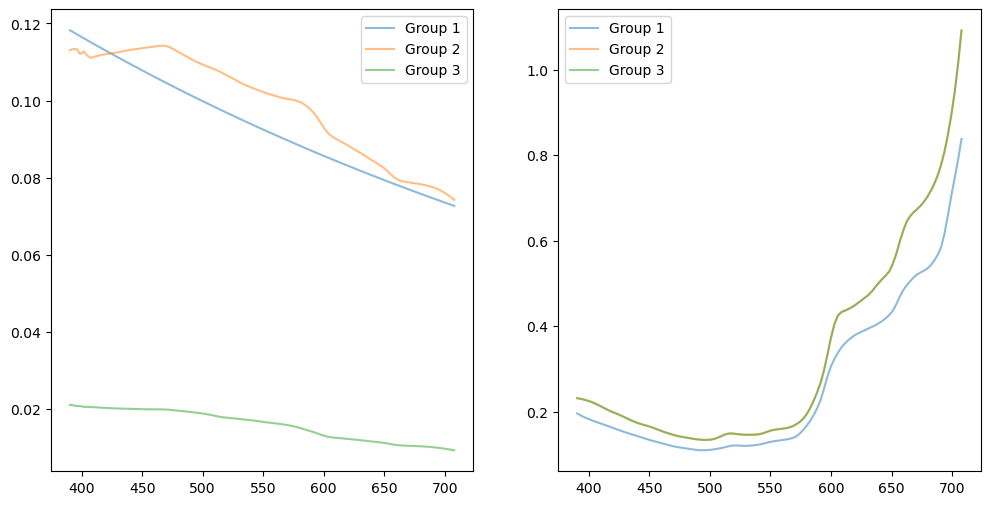

In [3]:
# compare AOP models    
f, axes = plt.subplots(1, 2, figsize=(12, 6))
for aop_group_num in range(1, 4):
    AOP_model = spectrum_utils.load_aop_model(aop_group_num=aop_group_num)
    wvs = AOP_model.index
    axes[0].plot(wvs, AOP_model.loc[wvs].bb_m + AOP_model.loc[wvs].bb_c, label=f"Group {aop_group_num}", alpha=0.5)
    axes[1].plot(wvs, AOP_model.loc[wvs].Kd_m + AOP_model.loc[wvs].Kd_c, label=f"Group {aop_group_num}", alpha=0.5)

# axes[0].set_title("Backscatter Model")
# axes[1].set_title("Kd Model")
axes[0].legend()
axes[1].legend();

In [4]:
# benthic counts data
validation_data = pd.read_csv(file_ops.DATA_DIR_FP / "CORAL_validation_data.csv")
# spectral data (PRISM-measured reflectance from nearby pixels)
spectra_raw = pd.read_csv(file_ops.DATA_DIR_FP / "CORAL_validation_spectra.csv")
spectra_raw.columns = spectra_raw.columns.astype(float)

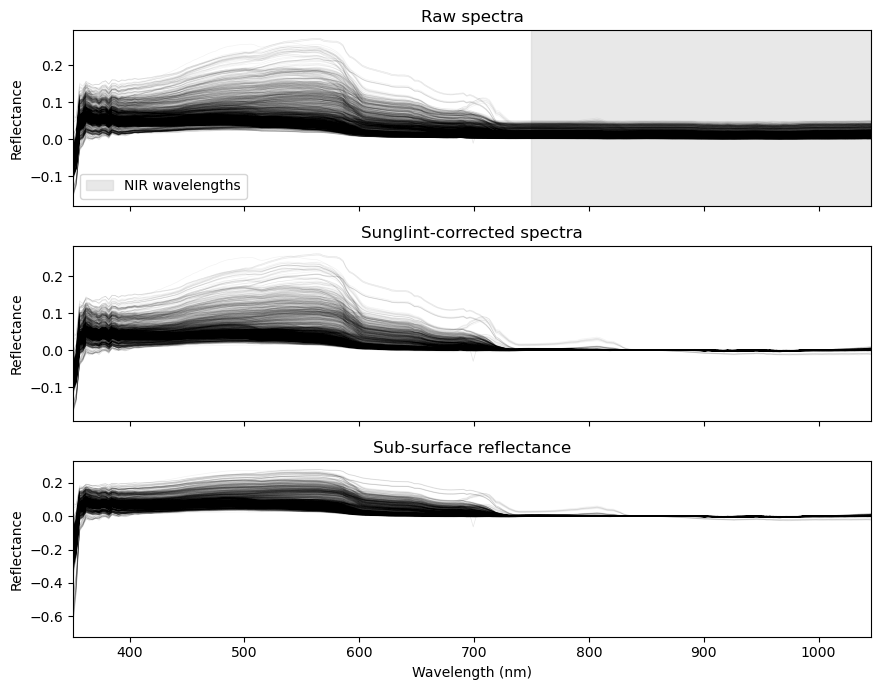

In [5]:
fig, ax = plt.subplots(3, 1, figsize=(9, 7), sharex=True)

NIR_wvs = (750, 1100)

ax[0].plot(spectra_raw.columns, spectra_raw.values.T, color=(0,0,0,0.05), lw=0.5);
# shade NIR waveband: (https://www.lidsen.com/journals/aeer/aeer-02-03-017)
ax[0].axvspan(min(NIR_wvs), max(spectra_raw.columns) if max(spectra_raw.columns) < max(NIR_wvs) else max(spectra_raw.columns), color='lightgrey', alpha=0.5, zorder=-2, label="NIR wavelengths")
ax[0].set_title("Raw spectra")
ax[0].legend()

# sun glint correction - subtract values between 750 and 1100 (NIR) from rest of data
spectra_deglinted = spectrum_utils.deglint_spectra(spectra_raw, NIR_wvs)

# calculate sub-surface reflectance (from Lee et al. 1998)
spectra_corrected = spectrum_utils.retrieve_subsurface_reflectance(spectra_deglinted)

ax[1].plot(spectra_deglinted.columns, spectra_deglinted.values.T, color=(0,0,0,0.05), lw=0.5);
ax[1].set_title("Sunglint-corrected spectra")

# plot corrected spectra
ax[2].plot(spectra_corrected.columns, spectra_corrected.values.T, color=(0,0,0,0.05), lw=0.5);
ax[2].set_title("Sub-surface reflectance")

for a in ax:
    a.set_xlim(spectra_corrected.columns.min(), spectra_corrected.columns.max())
    a.set_ylabel("Reflectance")
ax[2].set_xlabel("Wavelength (nm)")
    
plt.tight_layout()

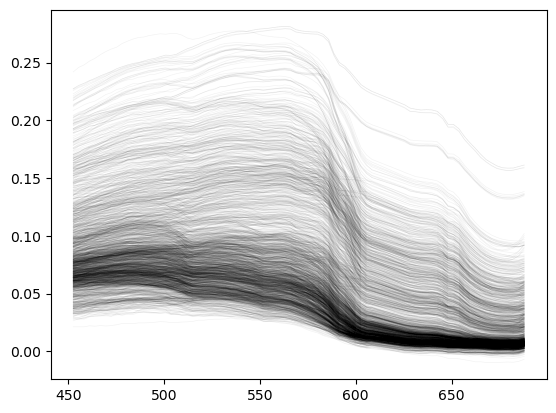

In [6]:
# clip spectra to AOP valid range (instrument calibration limitations)
ind = (spectra_corrected.columns > 450) & (spectra_corrected.columns < 690)
prism_spectra = spectra_corrected.loc[:, ind]
plt.plot(prism_spectra.columns, prism_spectra.values.T, color=(0,0,0,0.05), lw=0.5);

### Observations
- R2 does a pretty terrible job of describing goodness of fit
### TODO
- Is this covariance matrix useful?
- Some spectra e.g. i=888 are weird and jagged: is there a way to quantify and investigate these?

# Average Component-based Rb model

## Visualising spectra

In [7]:
file_ops.RESOURCES_DIR_FP

PosixPath('/Users/rt582/Library/CloudStorage/OneDrive-UniversityofCambridge/cambridge/phd/coralreflections/reflectance/resources')

In [8]:
f = file_ops.RESOURCES_DIR_FP / "spectral_library_clean_v3_PRISM_wavebands.csv"
df = pd.read_csv(f, skiprows=1).set_index('wavelength')
df.columns = df.columns.astype(float)
df = df.astype(float)
# clip to valid wv range
df = df.loc[:, prism_spectra.columns]

cats = df.index.unique()  # get categories

endmembers = {}
for cat in cats:
    ind = df.index == cat
    # select all spectra in category and calculate mean spectrum
    endmembers[cat] = df.loc[ind].mean(axis=0)
# create array of average spectrum for each category
endmember_array = np.array([spectrum.values for spectrum in endmembers.values()])

print('number of endmembers: ', len(endmember_array))
df.head()

number of endmembers:  11


,452.642775,455.475056,458.307394,461.139788,463.972238,466.804744,469.637306,472.469925,475.302600,478.135331,...,662.383497,665.219940,668.056439,670.892995,673.729607,676.566275,679.402999,682.239779,685.076616,687.913509
wavelength,,,,,,,,,,,,,,,,,,,,,
algae_crustose_coralline,0.024956,0.025307,0.025593,0.025889,0.026249,0.026669,0.027123,0.027563,0.027943,0.028233,...,0.049980,0.046018,0.042525,0.039782,0.037933,0.037039,0.037104,0.038188,0.040405,0.043873
algae_crustose_coralline,0.026762,0.027168,0.027538,0.027888,0.028217,0.028544,0.028896,0.029274,0.029645,0.029975,...,0.050251,0.045835,0.041945,0.038914,0.036896,0.035915,0.035968,0.037139,0.039624,0.043634
algae_crustose_coralline,0.047371,0.048106,0.048553,0.048921,0.049452,0.050271,0.051370,0.052624,0.053837,0.054839,...,0.109760,0.101359,0.093901,0.088094,0.084302,0.082658,0.083223,0.086160,0.091666,0.099919
algae_crustose_coralline,0.021885,0.022216,0.022436,0.022594,0.022775,0.023056,0.023476,0.024008,0.024575,0.025109,...,0.056447,0.052379,0.048849,0.046283,0.044905,0.044773,0.045785,0.047909,0.051187,0.055683
algae_crustose_coralline,0.015678,0.015880,0.016051,0.016234,0.016447,0.016688,0.016966,0.017266,0.017577,0.017888,...,0.037927,0.034945,0.032384,0.030518,0.029474,0.029246,0.029774,0.031100,0.033334,0.036624


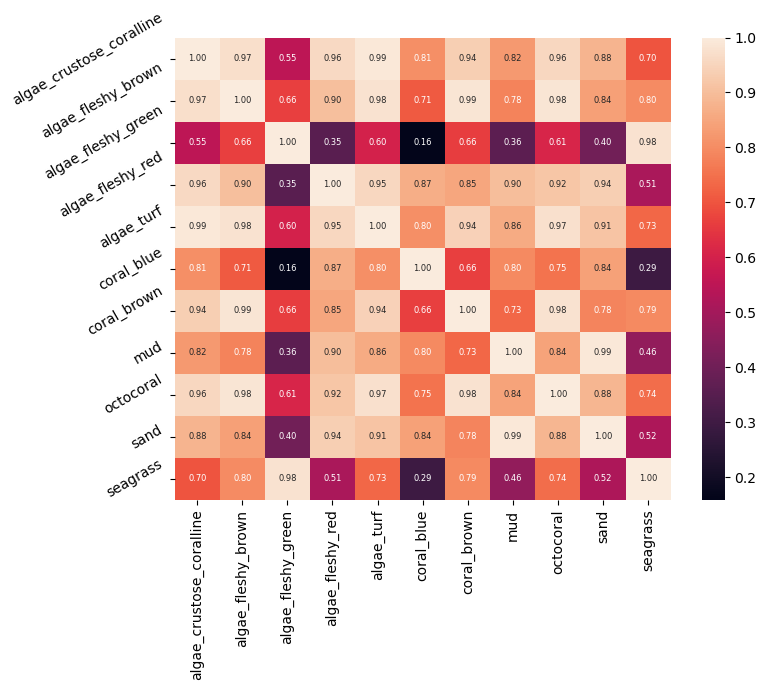

In [9]:
# visualise correlation between end-members
plt.figure(figsize=[8,6])
ax = sns.heatmap(np.corrcoef(endmember_array), annot=True, fmt='.2f', annot_kws={'fontsize':6})
ax.set_xticklabels(cats, rotation=90)
ax.set_yticklabels(cats, rotation=30);

In [10]:
# plot exponential decay function as function of wavelength and depth: sea at which depths peaks become invisible
# spectral angle may help with optimisation tolerance

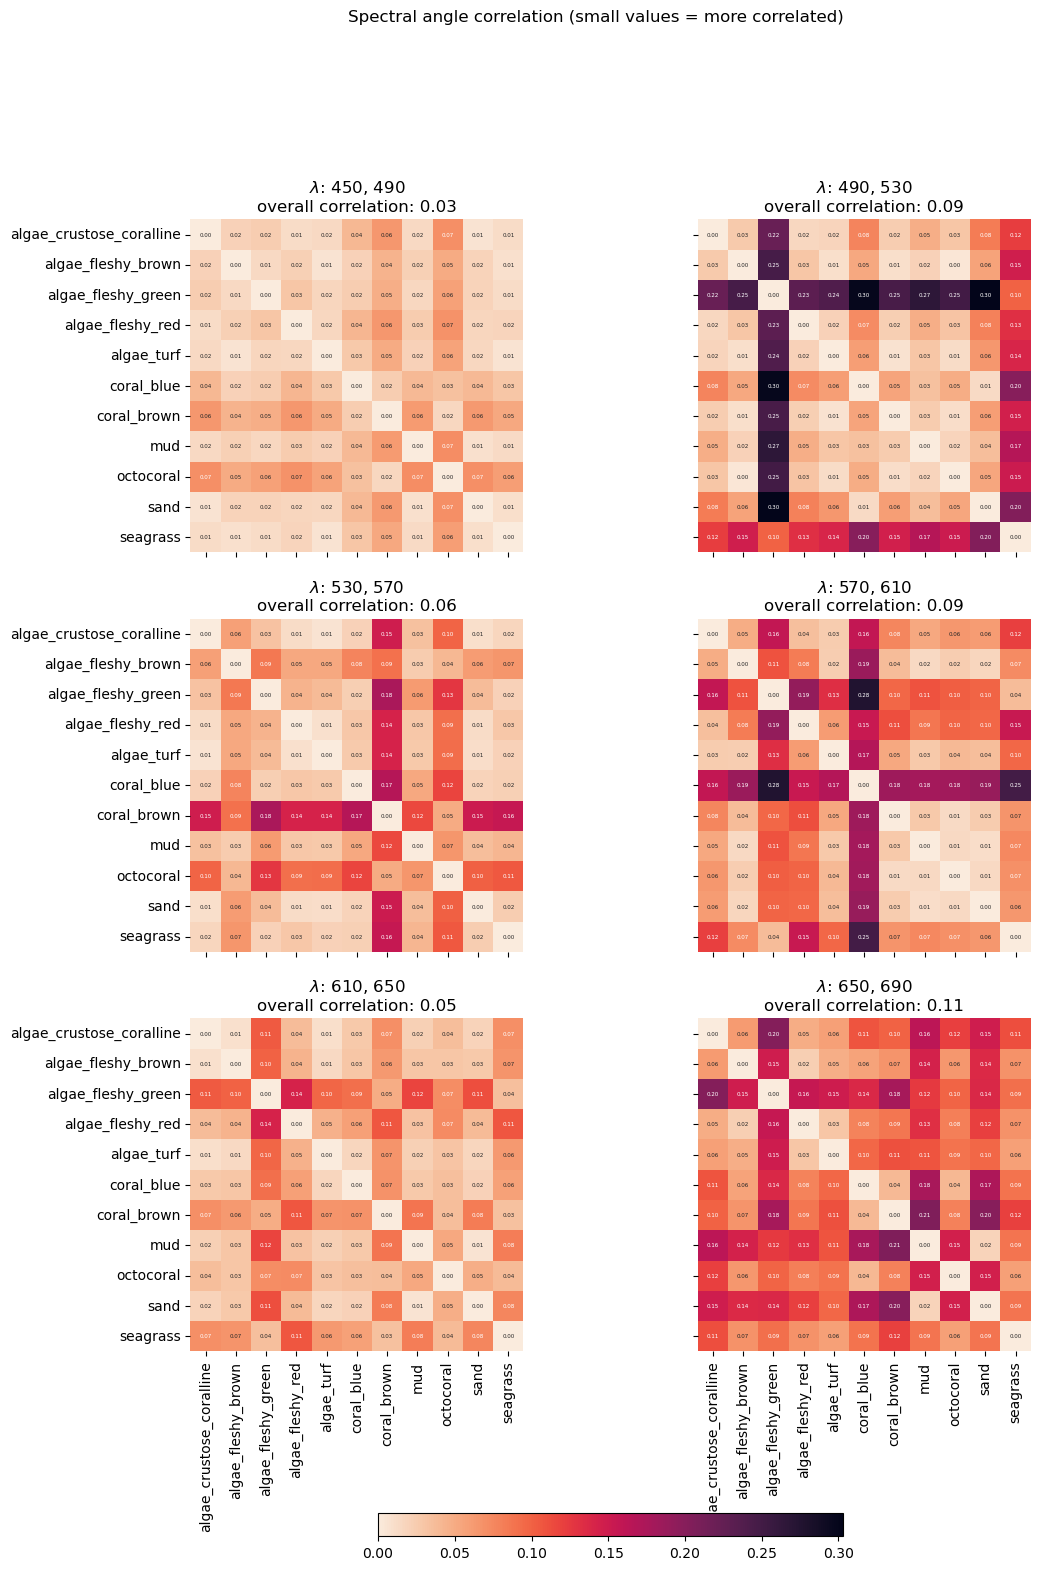

In [11]:
corr_type = "spectral_angle"

def compute_correlation(endmember_array: np.ndarray, corr_type: str = 'pearson') -> np.ndarray:
    """
    Compute correlation matrix between end-members.
    """
    if corr_type == 'pearson':
        return np.corrcoef(endmember_array)
    elif corr_type == "spectral_angle":
        return spectrum_utils.spectral_angle_correlation_matrix(endmember_array)
    else:
        raise ValueError(f"Invalid corr_type. Must be one of 'pearson' or 'spectral_angle'. Received: {corr_type}")

# Generate wavelength kernel pairs
min_wv, max_wv = 450, 670
kernel_width = 40
kernel_displacement = 40
wv_pairs = [(wv, wv+kernel_width) for wv in np.arange(min_wv, max_wv, kernel_displacement)]

corr_matrices = [compute_correlation(endmember_array[:, (prism_spectra.columns > min(wvs)) & (prism_spectra.columns < max(wvs))], corr_type=corr_type) for wvs in wv_pairs]
min_corr = min(matrix.min() for matrix in corr_matrices)
max_corr = max(matrix.max() for matrix in corr_matrices)

all_kernel_corrs = {}
num_rows = int(np.ceil(len(wv_pairs)/2))
fig, axes = plt.subplots(num_rows, 2, figsize=(12, 7*num_rows), sharex=True, sharey=True)

if corr_type == "spectral_angle":
    cmap = "rocket_r"
    plt.suptitle("Spectral angle correlation (small values = more correlated)")
else:
    cmap = "rocket"

for i, (wvs, corr_matrix) in enumerate(zip(wv_pairs, corr_matrices)):
    ax = sns.heatmap(corr_matrix, annot=True, fmt='.2f',
                     annot_kws={'fontsize':4}, ax=axes.flatten()[i],
                     vmin=min_corr, vmax=max_corr, cbar_kws={'shrink': 0.8}, cbar=False, cmap=cmap)  # Use global min/max for vmin/vmax
    
    ax.set_xticklabels(cats, rotation=90)
    ax.set_yticklabels(cats, rotation=0)
    
    # calculate the mean of the upper triangle of the correlation matrix (excluding diagonal)
    kernel_corr = corr_matrix[np.triu_indices(corr_matrix.shape[0], k=1)].mean()
    # all_kernel_corrs[wvs] = kernel_corr
    ax.set_title(f"$\\lambda$: {min(wvs)}, {max(wvs)}\noverall correlation: {kernel_corr:.2f}")
    ax.set_aspect("equal")
    
# remove any empty axes
for i in range(len(wv_pairs), len(axes.flatten())):
    fig.delaxes(axes.flatten()[i])

fig.colorbar(ax.collections[0], ax=axes, orientation='horizontal', fraction=0.2, pad=0.1, shrink=0.5, cmap=cmap)

plt.show()

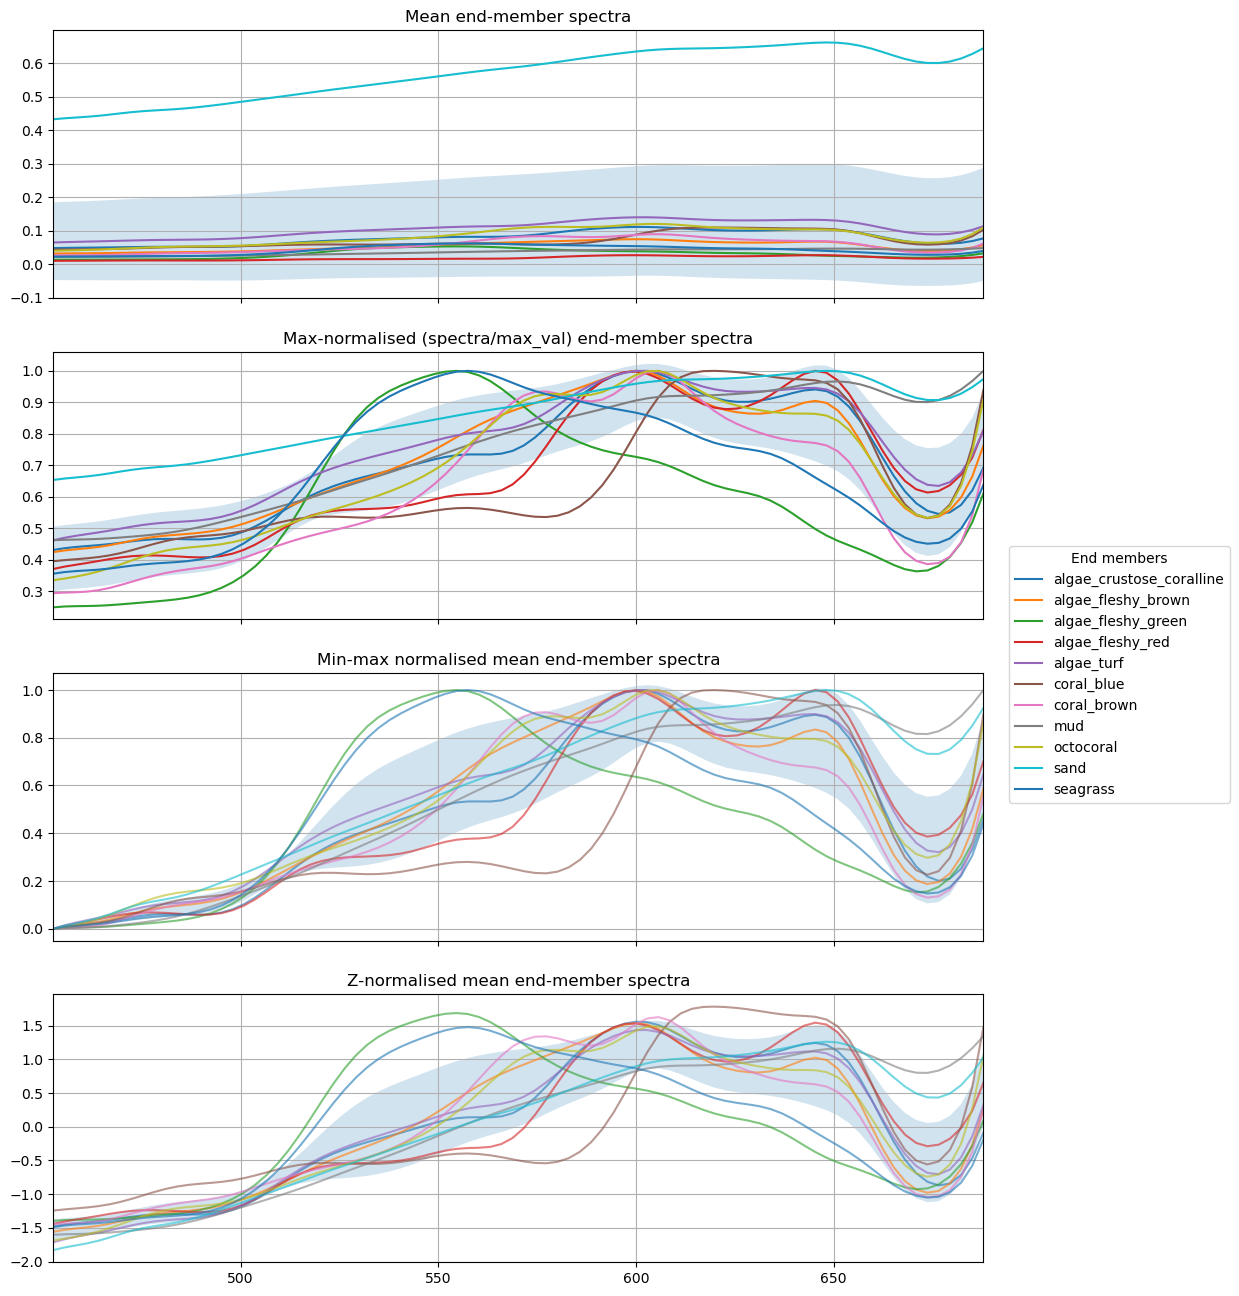

In [12]:
# plot endmembers with different scaling
endmembers_max = {cat: spectrum / spectrum.max() for cat, spectrum in endmembers.items()}
endmembers_minmax = {cat: (spectrum - spectrum.min()) / (spectrum.max() - spectrum.min()) for cat, spectrum in endmembers.items()}
endmembers_znorm = {cat: (spectrum - spectrum.mean(axis=0)) / spectrum.std(axis=0) for cat, spectrum in endmembers.items()}
    
fig, ax = plt.subplots(4, 1, figsize=[12,16], sharex=True)
for cat, spectrum in endmembers.items():
    ax[0].plot(spectrum.index, spectrum, label=cat)
    ax[1].plot(spectrum.index, endmembers_max[cat], label=cat)
    ax[2].plot(spectrum.index, endmembers_minmax[cat], label=cat, alpha=0.6)
    ax[3].plot(spectrum.index, endmembers_znorm[cat], label=cat, alpha=0.6)
    
# visualise spread of spectra
endmembers_maxscale_array = np.array([spectrum.values for spectrum in endmembers_max.values()])
endmembers_minmaxscale_array = np.array([spectrum.values for spectrum in endmembers_minmax.values()])
endmembers_znormscale_array = np.array([spectrum.values for spectrum in endmembers_znorm.values()])

for i, endmember_spectra in enumerate([endmember_array, endmembers_maxscale_array, endmembers_minmaxscale_array, endmembers_znormscale_array]):
    spectra_std = np.std(endmember_spectra, axis=0)
    spectra_mean = np.mean(endmember_spectra, axis=0)
    ax[i].fill_between(spectrum.index, spectra_mean - spectra_std, spectra_mean + spectra_std, alpha=0.2)
    
ax[0].set_xlim(min(spectrum.index), max(spectrum.index))

ax[0].set_title("Mean end-member spectra");
ax[1].set_title("Max-normalised (spectra/max_val) end-member spectra");
ax[2].set_title("Min-max normalised mean end-member spectra");
ax[3].set_title("Z-normalised mean end-member spectra");

ax[1].legend(bbox_to_anchor=(1.02, 0.3), title="End members")
[a.grid() for a in ax];

# remove spectrum variable
del spectrum

In [13]:
# # Generate wavelength kernel pairs
# min_wv, max_wv = 450, 670
# kernel_width = 5
# kernel_displacement = 5
# wv_pairs = [(wv, wv+kernel_width) for wv in np.arange(min_wv, max_wv, kernel_displacement)]


# fig, ax = plt.subplots(4, 1, figsize=[12,16], sharex=True)
# for cat, spectrum in endmembers.items():
#     ax[0].plot(spectrum.index, spectrum, label=cat)
#     ax[1].plot(spectrum.index, endmembers_max[cat], label=cat, alpha=0.6)
#     ax[2].plot(spectrum.index, endmembers_minmax[cat], label=cat, alpha=0.6)
#     ax[3].plot(spectrum.index, endmembers_znorm[cat], label=cat, alpha=0.6)
    
# ax[0].set_xlim(min(spectrum.index), max(spectrum.index))

# ax[1].legend(bbox_to_anchor=(1.02, 0.3), title="End members")
# # [a.grid(which='minor') for a in ax];
# for a in ax:
#     a.xaxis.set_major_locator(plt.MultipleLocator(10))
#     a.grid('major', axis='x')


# spectra_kernel_corrs = {}
# # for each type of spectral normalisation method
# for i, endmembers in enumerate([endmember_array, endmembers_maxscale_array, endmembers_minmaxscale_array, endmembers_znormscale_array]):
#     # calculate correlation matrices between end-members
#     corr_matrices = [compute_correlation(endmembers[:, (prism_spectra.columns > min(wvs)) & (prism_spectra.columns < max(wvs))], corr_type=corr_type) for wvs in wv_pairs]
#     # calculate mean correlation for each kernel pair
#     kernel_corrs = [corr_matrix[np.triu_indices(corr_matrix.shape[0], k=1)].mean() for corr_matrix in corr_matrices]
#     spectra_kernel_corrs[i] = kernel_corrs
    
#     ax[i].set_title(f"Mean end-member spectra\nMean correlation: {np.mean(kernel_corrs):.5f}")
#     ax[i].set_title(f"Max-normalised (spectra/max_val) end-member spectra\nMean correlation: {np.mean(kernel_corrs):.5f}")
#     ax[i].set_title(f"Min-max normalised mean end-member spectra\nMean correlation: {np.mean(kernel_corrs):.5f}")
#     ax[i].set_title(f"Z-normalised mean end-member spectra\nMean correlation: {np.mean(kernel_corrs):.5f}")


# min_corr = min([value for sublist in spectra_kernel_corrs.values() for value in sublist])
# max_corr = max([value for sublist in spectra_kernel_corrs.values() for value in sublist])

# spectra_kernel_corrs_norms = {k: (v - min_corr) / (max_corr - min_corr) for k, v in (spectra_kernel_corrs.items())}
# spectra_kernel_corrs_norms

# for i, endmembers in enumerate([endmember_array, endmembers_maxscale_array, endmembers_minmaxscale_array, endmembers_znormscale_array]):    # min_corr = min(all_kernel_corrs.values())
#     for j, wvs in enumerate(wv_pairs):
#         endmember_corrs = spectra_kernel_corrs_norms[i]
#         if corr_type == "spectral_angle":
#             alpha = (endmember_corrs[j])
#         else:
#             alpha = 0.3*(1 - endmember_corrs[j])
#         ax[i].axvspan(wvs[0], wvs[1], color=(0,0,0,alpha))
        
# if corr_type == "spectral_angle":
#     plt.suptitle("Spectral angle correlation (small values = more correlated)")
# # plot a colourbar of correlation values
# sm = plt.cm.ScalarMappable(cmap="grey", norm=plt.Normalize(vmin=min_corr, vmax=max_corr))
# plt.colorbar(sm, ax=ax, orientation='horizontal', label="Correlation value", fraction=0.2, pad=0.02, shrink=0.5, alpha=1)
# # plt.tight_layout()

In [14]:
# plot characteristics
kernel_width = 10
kernel_displacement = 10    # can be adjusted to return a rolling average
wv_pairs = [(wv, wv+kernel_width) for wv in np.arange(min_wv, max_wv, kernel_displacement)]

endmember_titles = ["Mean end-member spectra", "Max-normalised (spectra/max_val) end-member spectra", "Min-max normalised mean end-member spectra", "Z-normalised mean end-member spectra"]
for i, endmembers in enumerate([endmembers, endmembers_max, endmembers_minmax, endmembers_znorm]):
    subset_endmembers = {key: endmembers[key] for key in ["algae_fleshy_red", "algae_fleshy_green"]}
    # subset_endmembers = {
    #     "algae_fleshy_red": endmembers["algae_fleshy_red"],
    #     "algae_fleshy_red_2": endmembers["algae_fleshy_red"]+1,
    #     }
    plotting.plot_rolling_spectral_similarity(subset_endmembers, kernel_width, kernel_displacement, spectrum_utils.spectral_angle)
    plt.title(endmember_titles[i]);

NameError: name 'plt' is not defined

/var/folders/tp/x_9dbyf149d6kw_k79l_kk4m0000gq/T/ipykernel_32267/1783731407.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=30, fontsize=8)


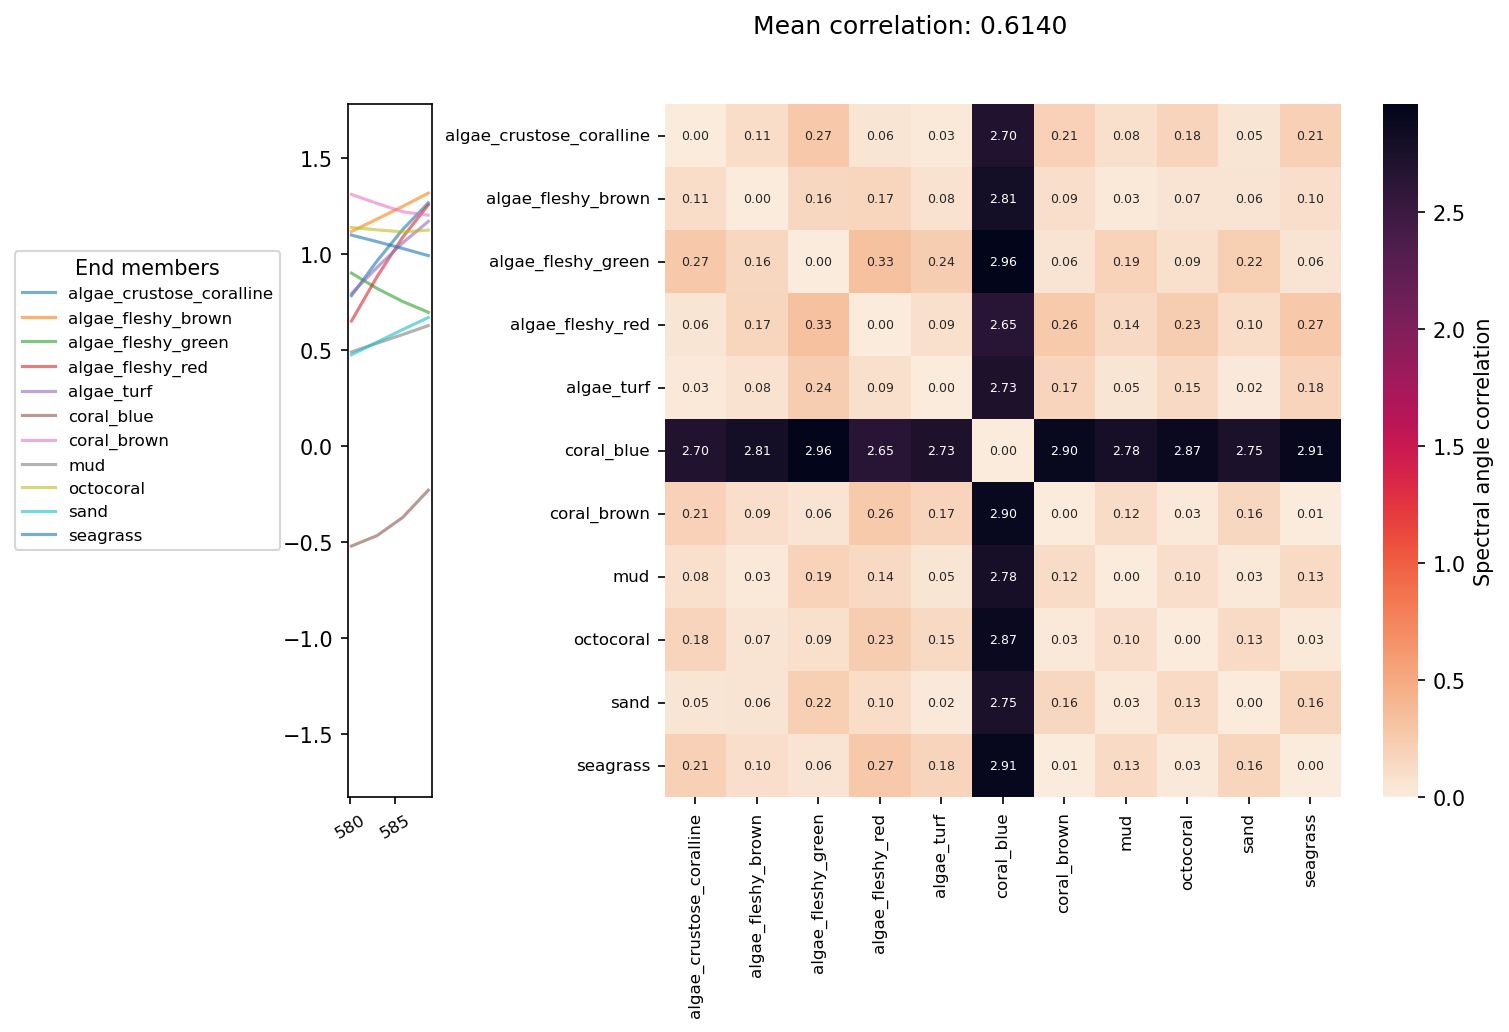

In [26]:
fig, ax = plt.subplots(1,2, figsize=(10, 6), dpi=150, 
                       width_ratios=[0.1,1]
                       )

wv_range = (580, 590)
ids = (prism_spectra.columns > min(wv_range)) & (prism_spectra.columns < max(wv_range))
wvs = prism_spectra.columns[ids]
for endmember in range(endmembers_znormscale_array.shape[0]):
    ax[0].plot(wvs, endmembers_znormscale_array[endmember, ids], label=cats[endmember], alpha=0.6)
    
corr_mat = spectrum_utils.spectral_angle_correlation_matrix(endmembers_znormscale_array[:, ids])
sns.heatmap(corr_mat, annot=True, fmt='.2f', annot_kws={'fontsize':6}, ax=ax[1], cmap='rocket_r', cbar_kws={'orientation': "vertical"})
# calculate mean of corr_mat
mean_corr = corr_mat[np.triu_indices(corr_mat.shape[0], k=1)].mean()

# formatting
ax[0].legend(title="End members", fontsize=8, bbox_to_anchor=(-.7, 0.8))
ax[0].set_ylim(endmembers_znormscale_array.min(), endmembers_znormscale_array.max())  # set y-axis limits to min/max of end-members to compare to whole spectrum
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=30, fontsize=8)
ax[1].collections[0].colorbar.set_label("Spectral angle correlation")
ax[1].set_xticklabels(cats, rotation=90, fontsize=8)
ax[1].set_yticklabels(cats, rotation=0, fontsize=8)
plt.suptitle(f"Mean correlation: {mean_corr:.4f}")
plt.subplots_adjust(wspace=0.5);

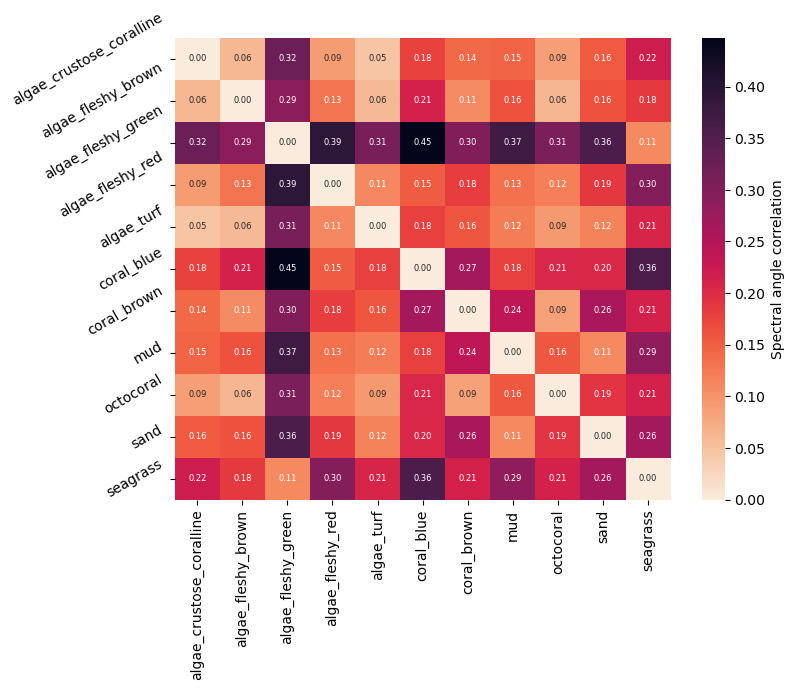

In [27]:
# visualise correlation between end-members
plt.figure(figsize=[8,6])
ax = sns.heatmap(spectrum_utils.spectral_angle_correlation_matrix(endmember_array), annot=True, fmt='.2f', annot_kws={'fontsize':6}, cmap='rocket_r')
ax.collections[0].colorbar.set_label("Spectral angle correlation")
ax.set_xticklabels(cats, rotation=90)
ax.set_yticklabels(cats, rotation=30);

## Noise estimation

In [28]:
spectra_corrected

,350.718103,353.548360,356.378673,359.209042,362.039467,364.869949,367.700487,370.531081,373.361731,376.192438,...,1020.218215,1023.061744,1025.905330,1028.748971,1031.592670,1034.436424,1037.280234,1040.124101,1042.968024,1045.812003
0,-0.088207,-0.040560,0.143655,0.137899,0.152775,0.158635,0.144351,0.150188,0.146312,0.155336,...,-0.000499,-0.000499,-0.000112,-0.000305,-0.000112,-0.001467,-0.000112,0.000467,0.000852,0.001044
1,-0.103556,-0.042124,0.136809,0.146524,0.161334,0.151524,0.147098,0.148012,0.141304,0.156534,...,-0.000722,-0.000722,-0.000142,0.001592,0.000244,0.001592,0.000244,0.003889,0.000630,0.000051
2,-0.091405,-0.042473,0.128363,0.137454,0.157239,0.150895,0.149538,0.150330,0.138878,0.146112,...,0.000323,-0.000063,-0.000256,0.001094,0.000323,-0.000836,-0.000063,-0.001029,0.000709,0.000131
3,-0.092976,-0.044062,0.139562,0.136712,0.151321,0.161355,0.149966,0.150192,0.144124,0.153896,...,-0.001072,-0.000298,-0.000491,0.000281,-0.001266,0.000667,-0.001266,0.002396,-0.002820,-0.000105
4,-0.085700,-0.038586,0.145053,0.138974,0.167120,0.156668,0.153677,0.155454,0.150873,0.154345,...,-0.000679,0.001057,-0.000486,0.000094,-0.000292,0.001442,-0.001066,0.002976,0.000094,0.001826
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1933,-0.164327,-0.103457,0.060112,0.075390,0.098312,0.083827,0.077933,0.077933,0.071151,0.079566,...,-0.000454,0.000511,0.001088,-0.000648,0.001088,0.000511,0.001473,-0.000454,0.001473,0.000511
1934,-0.157861,-0.100504,0.066598,0.077990,0.093763,0.090366,0.080362,0.084320,0.074695,0.083299,...,0.000391,0.000969,-0.000574,-0.000188,0.001546,0.000969,0.001546,0.000969,0.001354,-0.000188
1935,-0.139104,-0.087548,0.076950,0.078143,0.095309,0.095309,0.087076,0.086354,0.077547,0.086498,...,0.000590,0.000397,0.000590,0.000204,0.000782,0.001552,0.000975,0.000590,0.000204,0.000975
1936,-0.144804,-0.090247,0.072009,0.078622,0.097984,0.089546,0.085807,0.081577,0.075785,0.084501,...,0.000439,-0.000140,0.000632,0.000439,0.001017,0.001594,0.001594,0.001594,0.000439,0.001978


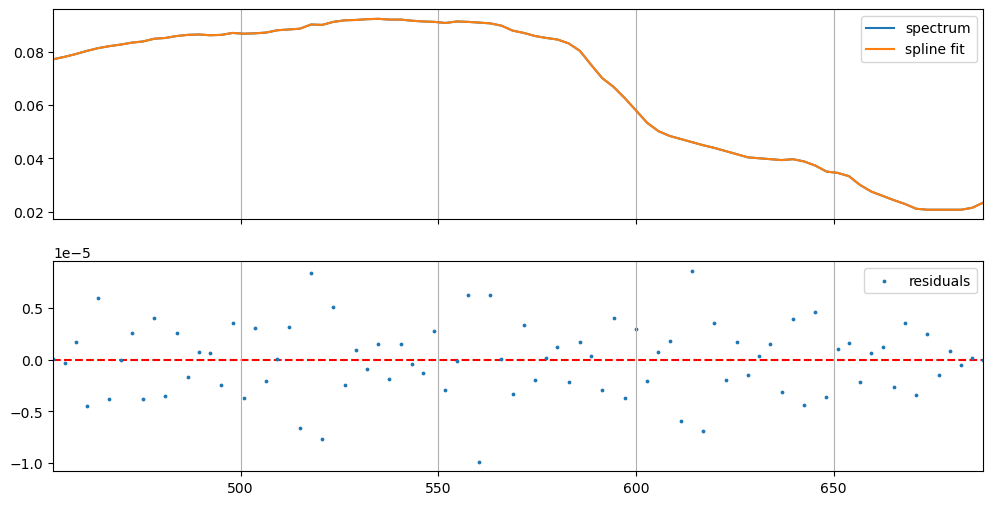

In [29]:
# example spectrum
i = 240

smoothing_factor = 1e-9
# visualise single spline
fig, ax = plt.subplots(2, 1, figsize=(12, 6), sharex=True)
# plot spectrum
ax[0].plot(prism_spectra.columns, prism_spectra.values[i], label="spectrum")
# fit spline
spline = UnivariateSpline(prism_spectra.columns, prism_spectra.values[i], s=smoothing_factor)
ax[0].plot(prism_spectra.columns, spline(prism_spectra.columns), label="spline fit")

# plot residuals
residuals = prism_spectra.values[i] - spline(prism_spectra.columns)
ax[1].scatter(prism_spectra.columns, residuals, s=3, label="residuals");
ax[1].hlines(0, prism_spectra.columns.min(), prism_spectra.columns.max(), color='r', linestyle='--', zorder=-2)

for a in ax:
    a.set_xlim(prism_spectra.columns.min(), prism_spectra.columns.max())
    a.grid(axis="x")
    a.legend()

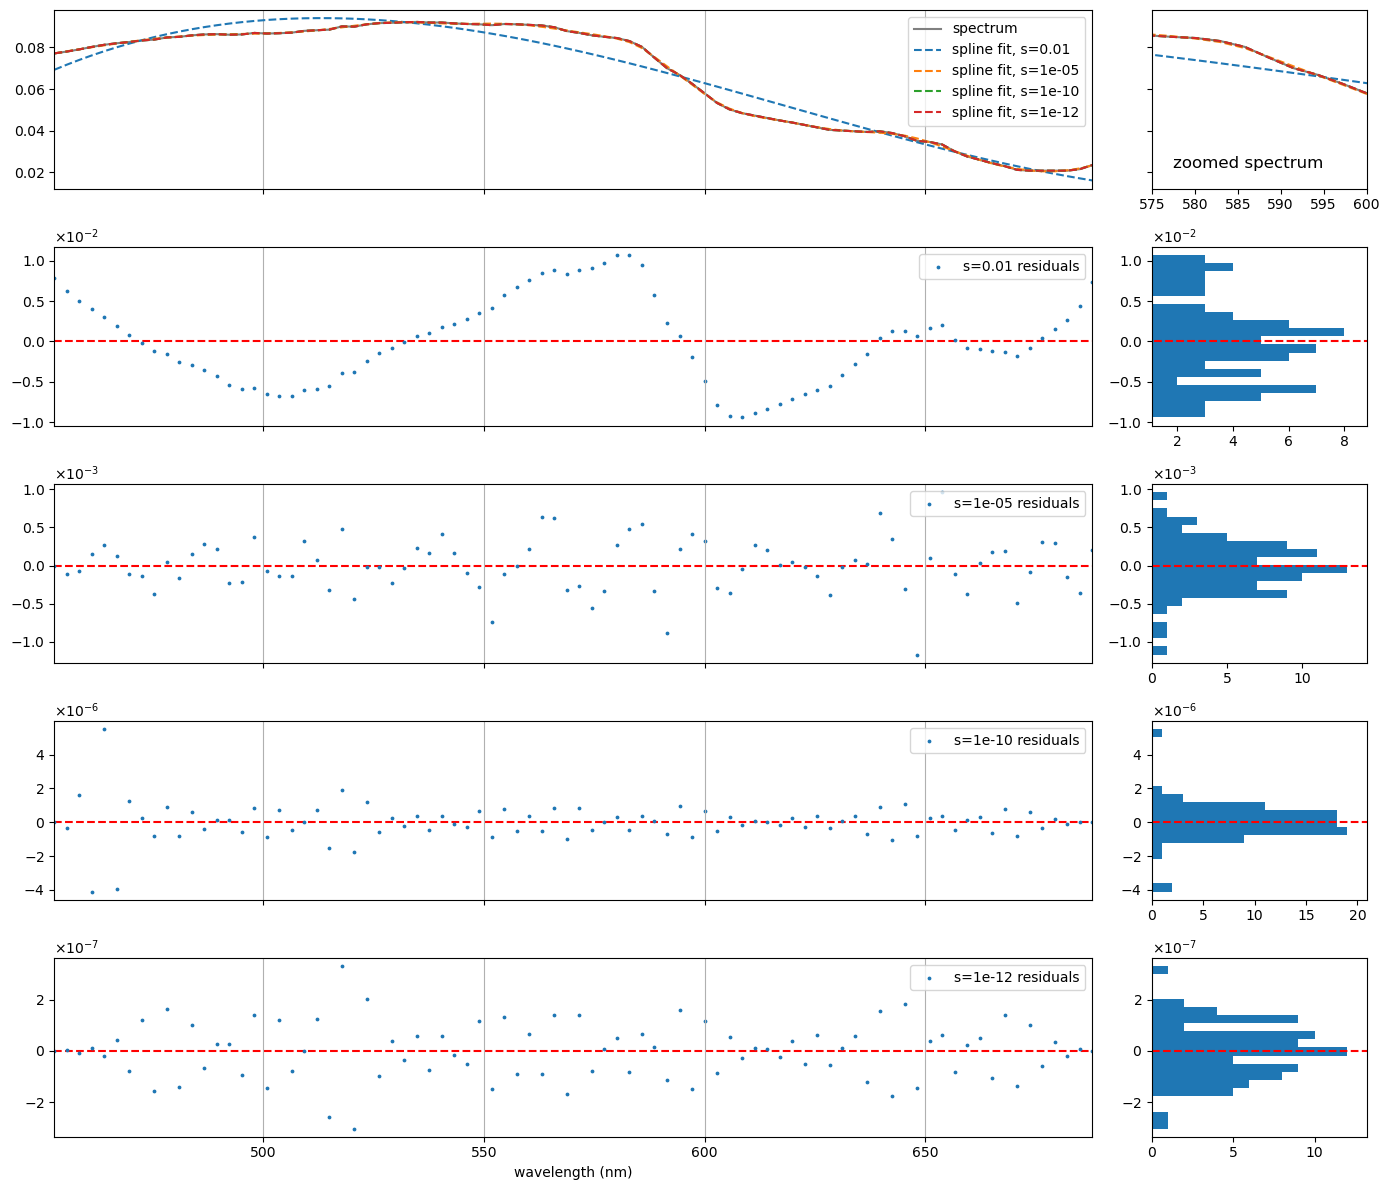

In [30]:
# smoothing_factors = [1e-2, 1e-3, 1e-5, 1e-8, 1e-10, 1e-12]
smoothing_factors = [1e-2, 1e-5, 1e-10, 1e-12]
zoom_wvs = (575, 600)

plotting.plot_spline_fits(smoothing_factors=smoothing_factors, spectrum=prism_spectra.iloc[i], zoom_wvs=zoom_wvs)

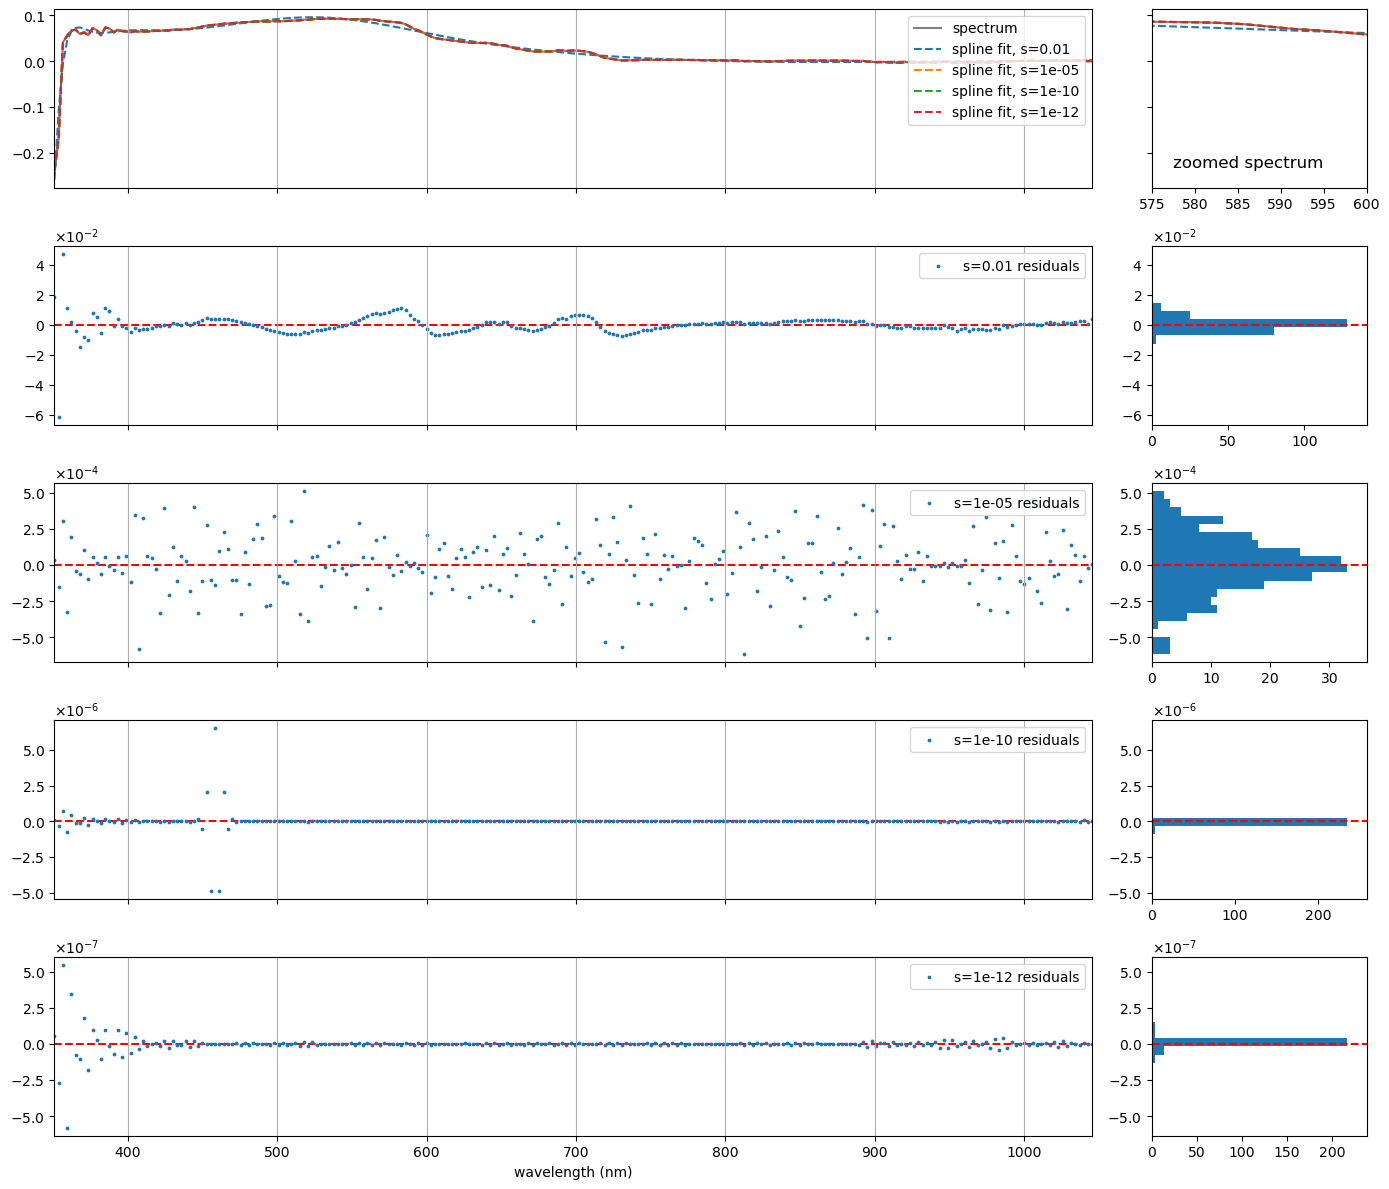

In [31]:
# plotting all wavelengths (uncropped spectra)
plotting.plot_spline_fits(smoothing_factors=smoothing_factors, spectrum=spectra_corrected.iloc[i], zoom_wvs=zoom_wvs)

In [32]:
# generate range of smoothing factors
smoothings = np.concatenate([np.logspace(-10, -3, 10), np.logspace(-3, 0, 90)])
# create an empty list to store the RSS values
rss_values = []

# Vectorized calculation of RSS for each smoothing factor
for s in tqdm(smoothings):
    spline_values = np.apply_along_axis(lambda row: UnivariateSpline(df.columns, row, s=s)(df.columns), axis=1, arr=df.values)
    rss = np.sum((df.values - spline_values) ** 2, axis=1)
    rss_values.append(rss)

# Convert rss_values to a NumPy array for easier manipulation if needed
rss_values = np.array(rss_values).T

  0%|          | 0/100 [00:00<?, ?it/s]

/var/folders/tp/x_9dbyf149d6kw_k79l_kk4m0000gq/T/ipykernel_32267/2349555226.py:8: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  spline_values = np.apply_along_axis(lambda row: UnivariateSpline(df.columns, row, s=s)(df.columns), axis=1, arr=df.values)


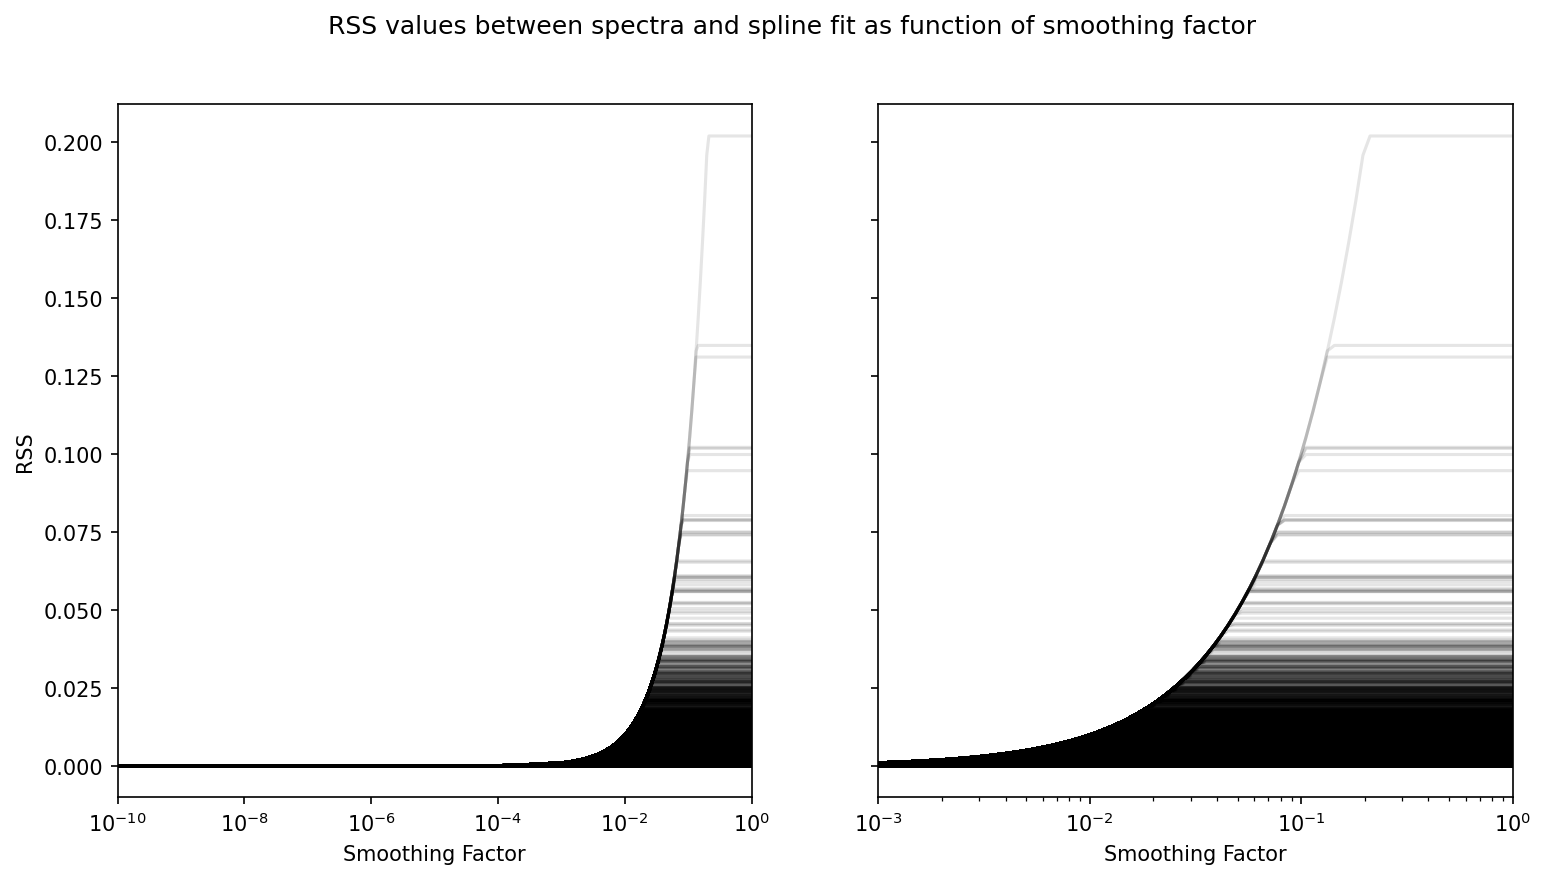

In [33]:
f, ax = plt.subplots(1,2, figsize=(12, 6), dpi=150, sharey=True)
smoothing_zoom_limits = (1e-3, 1) 

# plot the RSS values for each spectrum
ax[0].plot(smoothings, rss_values.T, c="k", alpha=0.1)
ax[0].set_xlim(min(smoothings), max(smoothings))
ax[1].plot(smoothings, rss_values.T, c="k", alpha=0.1)
ax[1].set_xlim(smoothing_zoom_limits)

ax[0].set_ylabel('RSS')
for a in ax:
    a.set_xscale('log')
    a.set_xlabel('Smoothing Factor')
plt.suptitle("RSS values between spectra and spline fit as function of smoothing factor");

## Fitting spectra

In [34]:
# # example of least-squares curve fit: a precursor to fitting via scipy.minimize
# i = 888
# plt.plot(prism_spectra.columns, prism_spectra.loc[i]);

# AOP_sub = AOP_model.loc[prism_spectra.columns]
# AOP_args = (AOP_sub.bb_m.values, AOP_sub.bb_c.values, AOP_sub.Kd_m.values, AOP_sub.Kd_c.values)

# # fitting curve with scalar Rb
# # function needs to be passed with lambda function since we need to pass additional arguments (AOP_args)
# p, cov = curve_fit(lambda x, bb, Kd, Rb, H: spectrum_utils.sub_surface_reflectance(x, bb, Kd, Rb, H, *AOP_args),
#                    prism_spectra.columns, # x values series (wavelengths)
#                    prism_spectra.loc[i],  # y values (example spectrum)
#                    p0=[0.1, 0.1, 0, 0],    # initialisation values for bb, Kd, Rb, H
#                    # value bounds (from AOP model). Rb min bound 0 since reflectance necessarily positive:
#                    bounds=([0, 0.01688, 0, -1], [0.41123, 3.17231, np.inf, np.inf]))    
# plt.plot(prism_spectra.columns, spectrum_utils.sub_surface_reflectance(prism_spectra.columns, *p, *AOP_args), color='red')
# # calculate spectrum r2
# r2 = r2_score(prism_spectra.loc[i], spectrum_utils.sub_surface_reflectance(prism_spectra.columns, *p, *AOP_args))
# plt.title(f"r$^2$: {r2:.5f}");

In [35]:
# len(AOP_args)
# AOP_args[0].shape
endmember_array.shape

(11, 84)

In [36]:
from scipy.optimize import Bounds

Bounds(0,2,keep_feasible=True)

Bounds(array([0]), array([2]), keep_feasible=array([ True]))

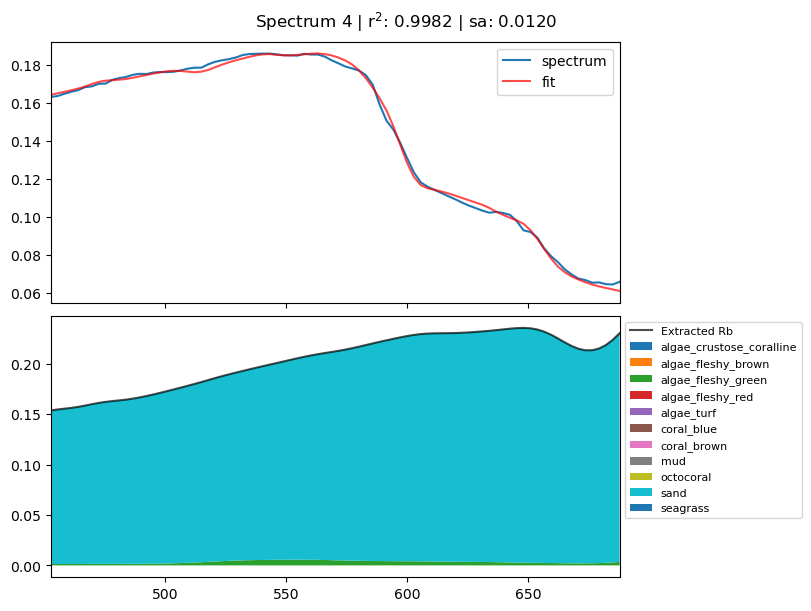

In [37]:
# minimise a single spectrum
i = 4

# load in endmember data
AOP_sub = AOP_model.loc[prism_spectra.columns]
AOP_args = (AOP_sub.bb_m.values, AOP_sub.bb_c.values, AOP_sub.Kd_m.values, AOP_sub.Kd_c.values)


endmember_bounds = (0, np.inf)
fit = minimize(
            spectrum_utils.r2_objective_fn,
            # spectrum_utils.spectral_angle_objective_fn,
            # initial parameter values
            x0=[0.1, 0.1, 0] + [0.0001] * len(endmember_array),
            # extra arguments passsed to the object function (and its derivatives)
            args=(prism_spectra.loc[i], # spectrum to fit (obs)
                  *AOP_args,    # wavelength-dependent backscatter and attenuation coefficients (bb_m, bb_c, Kd_m, Kd_c)
                  endmember_array  # typical end-member spectra
                  ),
            # constrain values
            bounds=[(0, 0.41123), (0.01688, 3.17231), (0, 50)] + [endmember_bounds] * len(endmember_array)) # may not always want to constrain this (e.g. for PCs)


fig, axs = plt.subplots(2, 1, sharex=True, constrained_layout=True, figsize=(8,6))

bb, K, H = fit.x[:3]
axs[0].plot(prism_spectra.columns, prism_spectra.loc[i], label='spectrum')
axs[0].plot(prism_spectra.columns, spectrum_utils.sub_surface_reflectance_Rb(prism_spectra.columns, endmember_array, bb, K, H, AOP_args, *fit.x[3:]), color='red', alpha=0.7, label='fit')
axs[0].legend()

axs[1].plot(prism_spectra.columns, spectrum_utils.Rb_endmember(endmember_array, *fit.x[-11:]), color='k', alpha=0.7, label='Extracted Rb')
axs[1].set_xlim(prism_spectra.columns.min(), prism_spectra.columns.max())

endmember_contribution = endmember_array * fit.x[-11:].reshape(-1,1)
y = np.zeros(endmember_contribution.shape[1])
for label, endmember in zip(endmembers, endmember_contribution):
    ynew = y + endmember
    axs[1].fill_between(prism_spectra.columns, y, ynew, label=label, lw=0)
    y = ynew
    
r2 = r2_score(prism_spectra.loc[i], spectrum_utils.sub_surface_reflectance_Rb(prism_spectra.columns, endmember_array, bb, K, H, AOP_args, *fit.x[3:]))
axs[1].legend(bbox_to_anchor=(1,1), fontsize=8)
# plt.suptitle(f"r$^2$: {fits.loc[i].r2:.4f} (spectrum {i})");
plt.suptitle(f"Spectrum {i} | r$^2$: {r2:.4f} | sa: {spectrum_utils.spectral_angle(prism_spectra.loc[i], spectrum_utils.sub_surface_reflectance_Rb(prism_spectra.columns, endmember_array, bb, K, H, AOP_args, *fit.x[3:])):.4f}");

In [38]:
file_ops.TMP_DIR_FP

PosixPath('/Users/rt582/Library/CloudStorage/OneDrive-UniversityofCambridge/cambridge/phd/coralreflections/tmp')

In [39]:
rerun = True

# Create a partial function with additional arguments fixed
partial_wrapper = partial(spectrum_utils._wrapper, of=spectrum_utils.r2_objective_fn, prism_spectra=prism_spectra, AOP_args=AOP_args, endmember_array=endmember_array, method="L-BFGS-B", tol=1e-6)
# partial_wrapper = partial(spectrum_utils._wrapper, of=spectrum_utils.spectral_angle_objective_fn, prism_spectra=prism_spectra, AOP_args=AOP_args, endmember_array=endmember_array, Rb_init=0.0001, method="L-BFGS-B", tol=1e-6)

# if rerun fitting process
if rerun:
    with mp.Pool() as pool:
        result = list(tqdm(pool.imap(partial_wrapper, prism_spectra.index), total=len(prism_spectra.index)))

    fits = pd.DataFrame(result, index=prism_spectra.index, columns=['bb', 'K', 'H'] + list(cats))
    # fits.to_csv('tmp/fits_avg_endmembers_new.csv')
# else load in values from tempfile
else:
    fits = pd.read_csv(file_ops.TMP_DIR_FP / "fits_avg_endmembers_new.csv", index_col=0)
    # fits = pd.read_csv('tmp/fits_avg_endmembers_og.csv', index_col=0) # original
    
fits.head()

  0%|          | 0/1938 [00:00<?, ?it/s]

,bb,K,H,algae_crustose_coralline,algae_fleshy_brown,algae_fleshy_green,algae_fleshy_red,algae_turf,coral_blue,coral_brown,mud,octocoral,sand,seagrass
0,0.164735,0.017302,2.020882,0.0,0.0,0.038676,0.0,0.000000,0.000000,0.0,0.00000,0.0,0.362247,0.000000
1,0.102862,0.081916,2.028054,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.00000,0.0,0.373781,0.000000
2,0.153994,0.033233,2.019369,0.0,0.0,0.007929,0.0,0.000089,0.000326,0.0,0.00428,0.0,0.339326,0.001118
3,0.104019,0.079514,2.064693,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.00000,0.0,0.377636,0.000000
4,0.116649,0.032623,2.001230,0.0,0.0,0.008324,0.0,0.000000,0.000000,0.0,0.00000,0.0,0.373513,0.000039


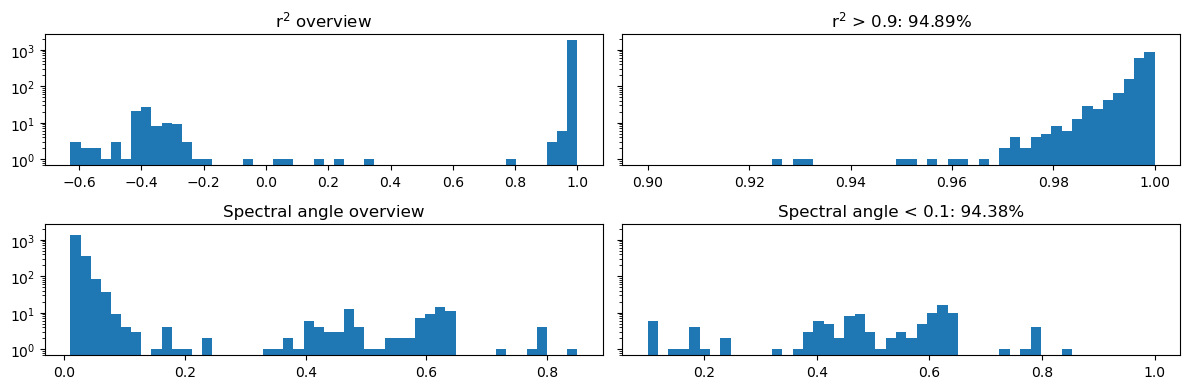

In [40]:
pred_spectra = spectrum_utils.generate_spectra_from_fits(fits, prism_spectra.columns, endmember_array, AOP_args)
metrics = spectrum_utils.calculate_metrics(prism_spectra, pred_spectra)
    
fig, ax = plt.subplots(2, 2, figsize=(12, 4), sharey=True)
ax[0,0].hist(metrics.r2, bins=50);
ax[0,0].set_yscale('log')
ax[0,0].set_title("r$^2$ overview")

min_r2 = 0.9
ax[0,1].hist(metrics.r2, bins=np.linspace(min_r2, 1, 50));
ax[0,1].set_title(f"r$^2$ > 0.9: {100*sum(metrics.r2 > min_r2)/len(metrics):.2f}%");

ax[1,0].hist(metrics.spectral_angle, bins=50);
ax[1,0].set_yscale('log')
ax[1,0].set_title("Spectral angle overview")

min_sa = 0.1
ax[1,1].hist(metrics.spectral_angle, bins=np.linspace(min_sa, 1, 50));
ax[1,1].set_title(f"Spectral angle < 0.1: {100*sum(metrics.spectral_angle < min_sa)/len(metrics):.2f}%");
plt.tight_layout()

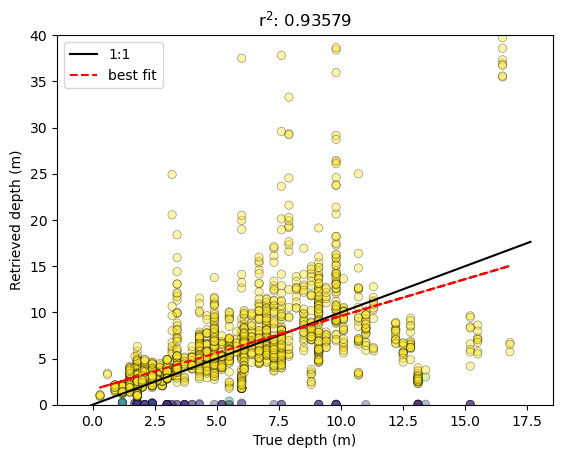

In [41]:
fig, ax = plt.subplots()
ma = ax.scatter(validation_data.Depth, fits.H, alpha=0.4, c=metrics.r2, edgecolor='k', lw=0.5)
ax.plot(ax.get_xlim(),ax.get_xlim(), color='k', label='1:1')

# calculate fits
p = np.polyfit(validation_data.Depth, fits.H, 1)
pred = np.polyval(p, validation_data.Depth)
r2 = r2_score(validation_data.Depth, pred)
ax.plot(validation_data.Depth, pred, color='r', ls='--', label="best fit")
# formatting
ax.set_title(f"r$^2$: {r2:.5f}")
ax.set_xlabel("True depth (m)")
ax.set_ylabel("Retrieved depth (m)")
ax.set_ylim(0,40)
# fig.colorbar(ma, label="r$^2$ value")
ax.legend()

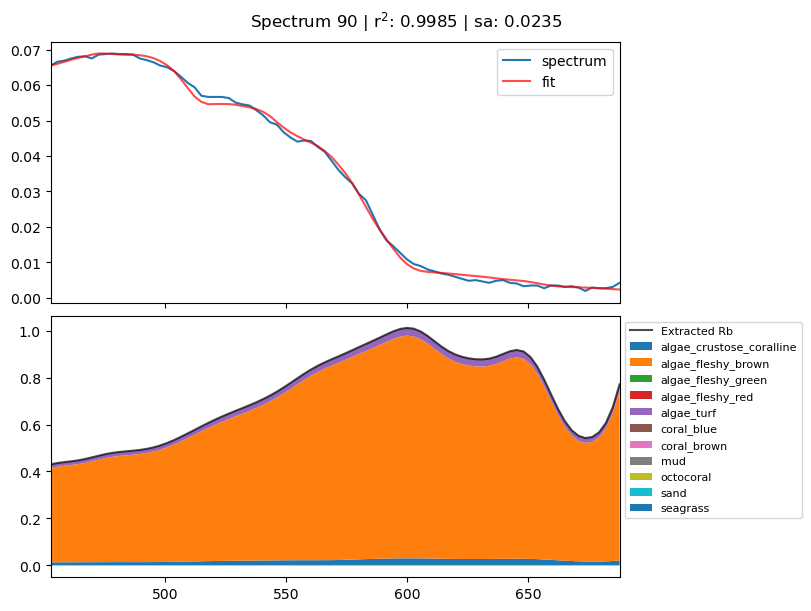

In [42]:
i = 90

fig, axs = plt.subplots(2, 1, sharex=True, constrained_layout=True, figsize=(8,6))

axs[0].plot(prism_spectra.columns, prism_spectra.loc[i], label='spectrum');

bb, K, H = fits.loc[i].values[:3]
axs[0].plot(prism_spectra.columns, spectrum_utils.sub_surface_reflectance_Rb(prism_spectra.columns, endmember_array, bb, K, H, AOP_args, *fits.loc[i].values[3:]), color='red', alpha=0.7, label='fit')
axs[0].legend(bbox_to_anchor=(1,1))

axs[1].plot(prism_spectra.columns, spectrum_utils.Rb_endmember(endmember_array, *fits.loc[i].values[-13:-2]), color='k', alpha=0.7, label='Extracted Rb')
axs[1].set_xlim(prism_spectra.columns.min(), prism_spectra.columns.max())

endmember_contribution = endmember_array * fits.loc[i].values[-13:-2].reshape(-1,1)
y = np.zeros(endmember_contribution.shape[1])
for label, endmember in zip(cats, endmember_contribution):
    ynew = y + endmember
    axs[1].fill_between(prism_spectra.columns, y, ynew, label=label, lw=0)
    y = ynew
    
axs[1].legend(bbox_to_anchor=(1,1), fontsize=8)
r2 = r2_score(prism_spectra.loc[i], spectrum_utils.sub_surface_reflectance_Rb(prism_spectra.columns, endmember_array, bb, K, H, AOP_args, *fits.loc[i].values[3:]))
sa = spectrum_utils.spectral_angle(prism_spectra.loc[i], spectrum_utils.sub_surface_reflectance_Rb(prism_spectra.columns, endmember_array, bb, K, H, AOP_args, *fits.loc[i].values[3:]))
plt.suptitle(f"Spectrum {i} | r$^2$: {r2:.4f} | sa: {sa:.4f}");

## With normalisation

In [43]:
from sklearn.preprocessing import MinMaxScaler
minmax_scaler = MinMaxScaler()

prism_spectra_minmax_norm = pd.DataFrame(minmax_scaler.fit_transform(prism_spectra), columns=prism_spectra.columns, index=prism_spectra.index)


In [44]:
rerun = True

# Create a partial function with additional arguments fixed

norm_endmember_array = minmax_scaler.fit_transform(endmember_array)

partial_wrapper = partial(spectrum_utils._wrapper, of=spectrum_utils.r2_objective_fn, prism_spectra=prism_spectra, AOP_args=AOP_args, endmember_array=endmember_array, method="BFGS", tol=1)
# partial_wrapper = partial(spectrum_utils._wrapper, of=spectrum_utils.spectral_angle_objective_fn, method="BFGS", tol=1, prism_spectra=prism_spectra_minmax_norm, AOP_args=AOP_args, endmember_array=norm_endmember_array, Rb_init=0.0001)

# if rerun fitting process
if rerun:
    with mp.Pool() as pool:
        minmax_result = list(tqdm(pool.imap(partial_wrapper, prism_spectra.index), total=len(prism_spectra.index)))

    minmax_fits = pd.DataFrame(minmax_result, index=prism_spectra.index, columns=['bb', 'K', 'H'] + list(cats))
    # minmax_fits.to_csv('tmp/minmax_fits_avg_endmembers_new.csv')
# else load in values from tempfile
else:
    minmax_fits = pd.read_csv(file_ops.TMP_DIR_FP / "minmax_fits_avg_endmembers_new.csv", index_col=0)
    # minmax_fits = pd.read_csv('tmp/minmax_fits_avg_endmembers_og.csv', index_col=0) # original
    
minmax_fits.head()

  0%|          | 0/1938 [00:00<?, ?it/s]

/Users/rt582/Library/CloudStorage/OneDrive-UniversityofCambridge/cambridge/phd/coralreflections/reflectance/spectrum_utils.py:274: RuntimeWarning: Method BFGS cannot handle bounds.
  fit = minimize(
/Users/rt582/Library/CloudStorage/OneDrive-UniversityofCambridge/cambridge/phd/coralreflections/reflectance/spectrum_utils.py:274: RuntimeWarning: Method BFGS cannot handle bounds.
  fit = minimize(
/Users/rt582/Library/CloudStorage/OneDrive-UniversityofCambridge/cambridge/phd/coralreflections/reflectance/spectrum_utils.py:274: RuntimeWarning: Method BFGS cannot handle bounds.
  fit = minimize(
/Users/rt582/Library/CloudStorage/OneDrive-UniversityofCambridge/cambridge/phd/coralreflections/reflectance/spectrum_utils.py:274: RuntimeWarning: Method BFGS cannot handle bounds.
  fit = minimize(
/Users/rt582/Library/CloudStorage/OneDrive-UniversityofCambridge/cambridge/phd/coralreflections/reflectance/spectrum_utils.py:274: RuntimeWarning: Method BFGS cannot handle bounds.
  fit = minimize(
/User

,bb,K,H,algae_crustose_coralline,algae_fleshy_brown,algae_fleshy_green,algae_fleshy_red,algae_turf,coral_blue,coral_brown,mud,octocoral,sand,seagrass
0,0.100241,0.099734,-0.001935,0.001124,0.017029,0.056664,-0.014197,0.018945,-0.061651,0.003058,-0.021145,-0.012981,0.236207,0.060157
1,0.100240,0.099735,-0.003739,0.001705,0.017330,0.056614,-0.013982,0.019457,-0.060924,0.003707,-0.020889,-0.012185,0.235682,0.060153
2,0.100215,0.099783,-0.008552,0.001734,0.016335,0.053063,-0.013081,0.018324,-0.056927,0.003672,-0.019662,-0.011273,0.220109,0.056412
3,0.100243,0.099731,0.000974,0.000984,0.017181,0.057320,-0.014420,0.018948,-0.062389,0.003254,-0.021505,-0.013078,0.237033,0.060836
4,0.100247,0.099722,-0.002851,0.001845,0.017734,0.057738,-0.014170,0.019948,-0.061964,0.003969,-0.021092,-0.012093,0.239907,0.061313


  0%|          | 0/1938 [00:00<?, ?it/s]

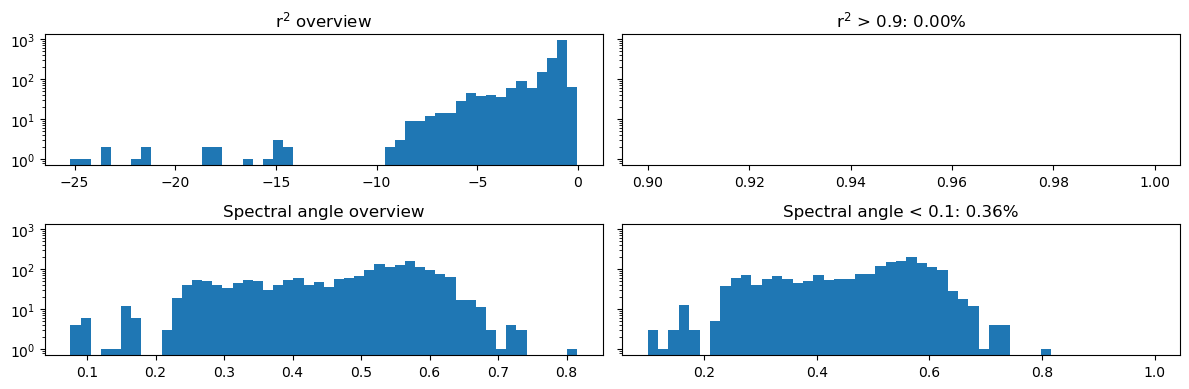

In [45]:
# assign nans to r2 column
minmax_fits['r2'] = np.nan
minmax_fits['spectral_angle'] = np.nan

for i, row in tqdm(minmax_fits.iterrows(), total=len(minmax_fits)):
    bb_m, bb_c, Kd_m, Kd_c = AOP_args
    bb, K, H = row.values[:3]
    pred = spectrum_utils.sub_surface_reflectance_Rb(prism_spectra.columns, norm_endmember_array, bb, K, H, AOP_args, *row.values[3:-2])
    minmax_fits.loc[i, 'r2'] = r2_score(prism_spectra.loc[i], pred)
    minmax_fits.loc[i, 'spectral_angle'] = spectrum_utils.spectral_angle(prism_spectra.loc[i], pred)
    
fig, ax = plt.subplots(2, 2, figsize=(12, 4), sharey=True)
ax[0,0].hist(minmax_fits.r2, bins=50);
ax[0,0].set_yscale('log')
ax[0,0].set_title("r$^2$ overview")

min_r2 = 0.9
ax[0,1].hist(minmax_fits.r2, bins=np.linspace(min_r2, 1, 50));
ax[0,1].set_title(f"r$^2$ > 0.9: {100*sum(minmax_fits.r2 > min_r2)/len(minmax_fits):.2f}%");

ax[1,0].hist(minmax_fits.spectral_angle, bins=50);
ax[1,0].set_yscale('log')
ax[1,0].set_title("Spectral angle overview")

min_sa = 0.1
ax[1,1].hist(minmax_fits.spectral_angle, bins=np.linspace(min_sa, 1, 50));
ax[1,1].set_title(f"Spectral angle < 0.1: {100*sum(minmax_fits.spectral_angle < min_sa)/len(minmax_fits):.2f}%");
plt.tight_layout()


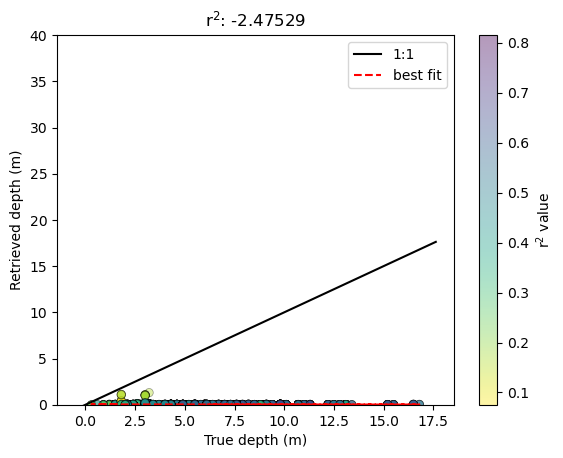

In [46]:
fig, ax = plt.subplots()
ma = ax.scatter(validation_data.Depth, minmax_fits.H, alpha=0.4, c=minmax_fits.spectral_angle, edgecolor='k', cmap="viridis_r", lw=0.5)
ax.plot(ax.get_xlim(),ax.get_xlim(), color='k', label='1:1')

# calculate minmax_fits
p = np.polyfit(validation_data.Depth, minmax_fits.H, 1)
pred = np.polyval(p, validation_data.Depth)
r2 = r2_score(validation_data.Depth, pred)
ax.plot(validation_data.Depth, pred, color='r', ls='--', label="best fit")
# formatting
ax.set_title(f"r$^2$: {r2:.5f}")
ax.set_xlabel("True depth (m)")
ax.set_ylabel("Retrieved depth (m)")
ax.set_ylim(0,40)
fig.colorbar(ma, label="r$^2$ value")
ax.legend()

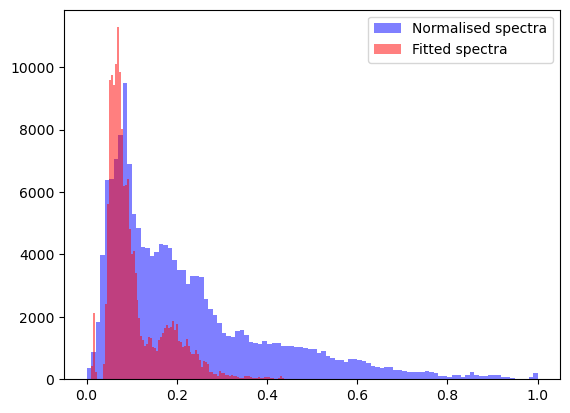

In [47]:
# create dataframe of spectra from minmax_result (apply spectrum_utils.sub_surface_reflectance_Rb() to each row)
minmax_spectra = pd.DataFrame([spectrum_utils.sub_surface_reflectance_Rb(prism_spectra.columns, norm_endmember_array, *row.values[:3], AOP_args, *row.values[3:-2]) for i, row in minmax_fits.iterrows()], index=minmax_fits.index, columns=prism_spectra.columns)
# plot histogram of values of prism_spectra_minmax_norm and minmax_spectra
plt.hist(prism_spectra_minmax_norm.values.flatten(), bins=100, alpha=0.5, label="Normalised spectra", color="b");

minmax_spectra_clean = minmax_spectra[(minmax_spectra.values < 1).all(axis=1)]
# minmax_spectra_clean

plt.hist(minmax_spectra_clean.values.flatten(), bins=100, alpha=0.5, label="Fitted spectra", color="r");
plt.legend()

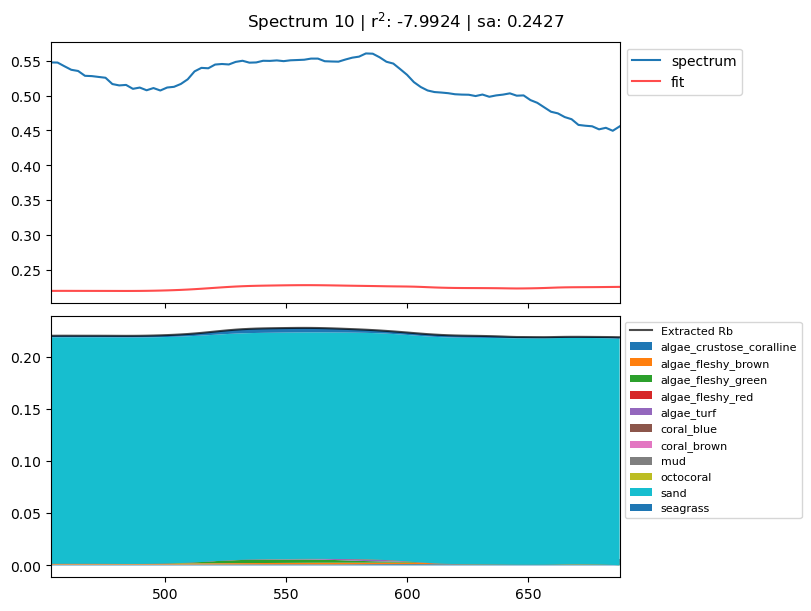

In [48]:
i = 10

fig, axs = plt.subplots(2, 1, sharex=True, constrained_layout=True, figsize=(8,6))

axs[0].plot(prism_spectra_minmax_norm.columns, prism_spectra_minmax_norm.loc[i], label='spectrum');

bb, K, H = minmax_fits.loc[i].values[:3]
axs[0].plot(prism_spectra_minmax_norm.columns, spectrum_utils.sub_surface_reflectance_Rb(prism_spectra_minmax_norm.columns, norm_endmember_array, bb, K, H, AOP_args, *minmax_fits.loc[i].values[3:-2]), color='red', alpha=0.7, label='fit')
axs[0].legend(bbox_to_anchor=(1,1))

axs[1].plot(prism_spectra_minmax_norm.columns, spectrum_utils.Rb_endmember(norm_endmember_array, *minmax_fits.loc[i].values[-13:-2]), color='k', alpha=0.7, label='Extracted Rb')
axs[1].set_xlim(prism_spectra_minmax_norm.columns.min(), prism_spectra_minmax_norm.columns.max())

endmember_contribution = norm_endmember_array * minmax_fits.loc[i].values[-13:-2].reshape(-1,1)
y = np.zeros(endmember_contribution.shape[1])
for label, endmember in zip(cats, endmember_contribution):
    ynew = y + endmember
    axs[1].fill_between(prism_spectra_minmax_norm.columns, y, ynew, label=label, lw=0)
    y = ynew
    
axs[1].legend(bbox_to_anchor=(1,1), fontsize=8)
r2 = minmax_fits.loc[i].r2
sa = minmax_fits.loc[i].spectral_angle
plt.suptitle(f"Spectrum {i} | r$^2$: {r2:.4f} | sa: {sa:.4f}");

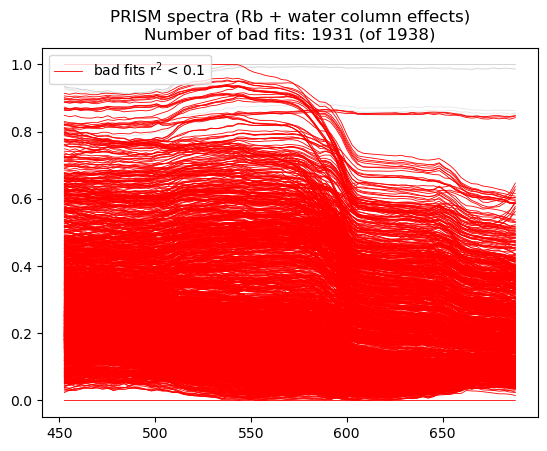

In [49]:
r2_threshold = 0.9
sa_threshold = 0.1

# bad_fits = minmax_fits[minmax_fits.r2 < threshold]
# good_fits = minmax_fits[minmax_fits.r2 >= threshold]
bad_fits = minmax_fits[minmax_fits.spectral_angle > sa_threshold]
good_fits = minmax_fits[minmax_fits.spectral_angle <= sa_threshold]

plt.title("")
plt.plot(prism_spectra_minmax_norm.columns, prism_spectra_minmax_norm.loc[bad_fits.index].values.T, color='red', lw=0.6)
plt.plot(prism_spectra_minmax_norm.columns, prism_spectra_minmax_norm.loc[good_fits.index].values.T, color='k', alpha=0.1, lw=0.6, zorder=-2);
plt.plot([], [], color="red", lw=0.6, label=f"bad fits r$^2$ < {sa_threshold}")
plt.title(f'PRISM spectra (Rb + water column effects)\nNumber of bad fits: {bad_fits.shape[0]} (of {len(fits)})')
plt.legend();

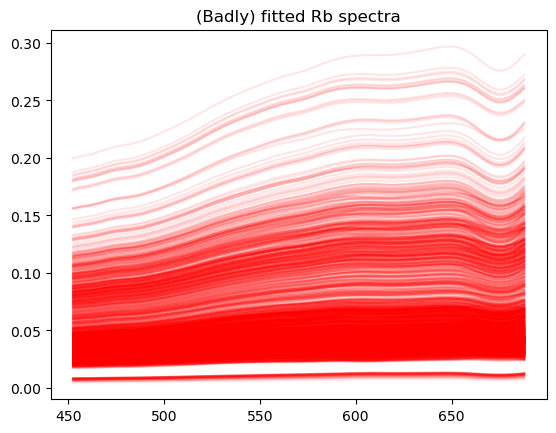

In [50]:
fig, ax = plt.subplots()
ax.set_title("(Badly) fitted Rb spectra")

for i, row in bad_fits.iterrows():
    Rb = spectrum_utils.Rb_endmember(endmember_array, *minmax_fits.loc[i, cats].values)
    ax.plot(prism_spectra.columns, Rb, color='r', alpha=0.1)

In [51]:
# fit_metrics = pd.concat([fits, ])
# plot bb, K, H
fig = px.scatter_3d(minmax_fits, x='bb', y='K', z='H', color='spectral_angle', 
                    color_continuous_scale='viridis_r', opacity=0.5,
                    labels={'r2': 'R-squared'})

fig.show()

In [52]:
# plot bb, K, H
fig = px.scatter_3d(minmax_fits, x='bb', y='K', z='H', color='r2', 
                    color_continuous_scale='viridis', opacity=0.5,
                    labels={'r2': 'R-squared'})

fig.show()

In [53]:
# map between in-situ validation data and endmember categories
endmember_map = {
    'algae_crustose_coralline': ['algCCA'],
    'algae_fleshy_brown': ['algMacBrn'],
    'algae_fleshy_green': ['algMacGrn', 'algMacMix', 'algMacUnk', 'algCyano'],
    'algae_fleshy_red': ['algMacRed'],
    'algae_turf': ['algTurf'],
    'coral_blue': [],
    'coral_brown': ['crlCoral'],
    'mud': ['sedMud'],
    'octocoral': ['othOcto'],
    'sand': ['sedSand', 'crlBleach', 'sedLimest', 'sedRubble'],
    'seagrass': ['othSeagr'],
    # 'other': ['othClam', 'othInvert', 'othOther', 'othSponge', 'othUrchin']  # ignoring as max count is 3, and they don't fit categories well
}

# create empty dataframe with correct rows and column headers
validation_data_mapped = pd.DataFrame(index=validation_data.index, columns=endmember_map)

for endmember_dimensionality_reduction, validation_fields in endmember_map.items():
    # fill in validation data with sum of all fields in the category
    validation_data_mapped.loc[:, endmember_dimensionality_reduction] = validation_data.loc[:, validation_fields].sum(axis=1) 
# validation_data_mapped

# normalise validation data
validation_data_mapped_norm = validation_data_mapped.divide(validation_data_mapped.sum(axis=1), axis=0) # first sum along rows, then divide by row sum
# normalise fitted data
fits_norm = fits.loc[:, cats]
fits_norm = fits_norm.divide(fits_norm.sum(axis=1), axis=0)

In [54]:
# assign new 'coral' class as sum of blue and brown coral
validation_data_mapped_norm['coral'] = validation_data_mapped_norm[['coral_blue', 'coral_brown']].sum(axis=1)
fits_norm['coral'] = fits_norm[['coral_blue', 'coral_brown']].sum(axis=1)

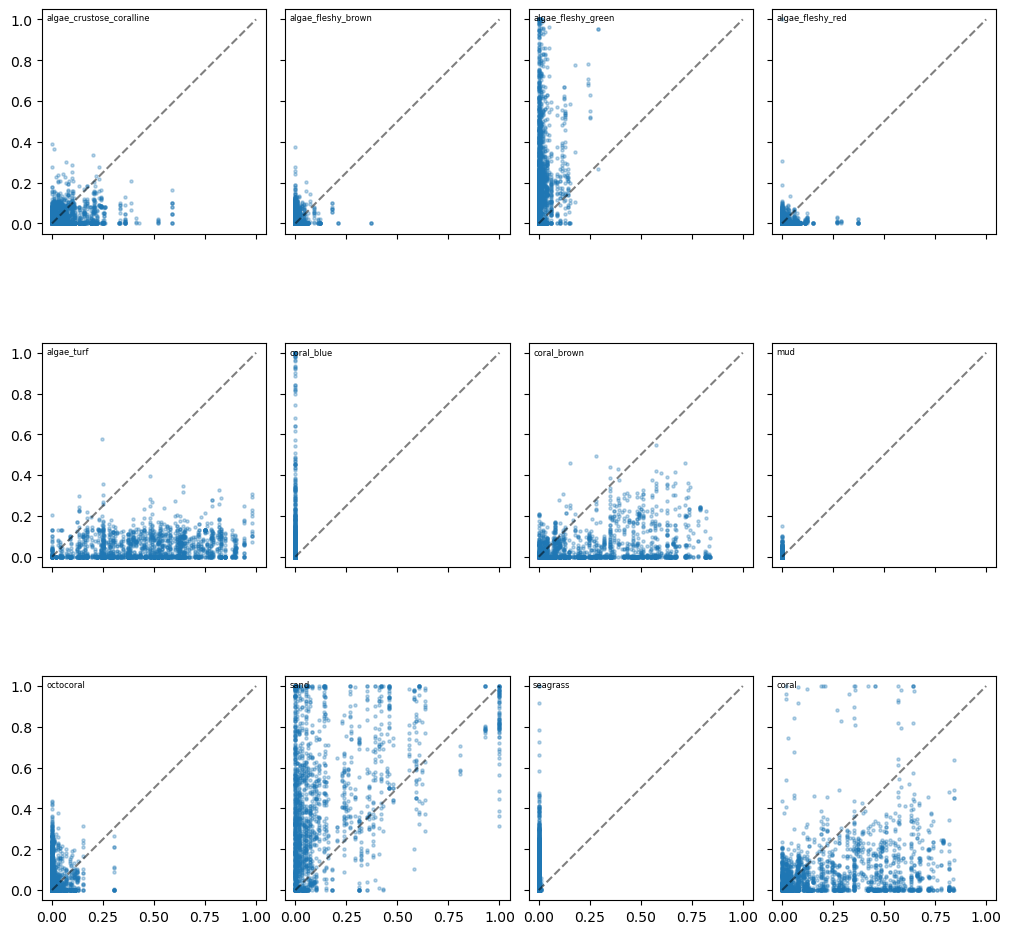

In [55]:
fig, axs = plt.subplots(3, 4, figsize=[10, 10], sharex=True, sharey=True, constrained_layout=True)

for endmember, ax in zip(fits_norm.columns, axs.flat):
    ax.scatter(validation_data_mapped_norm[endmember], fits_norm[endmember], s=5, alpha=0.3)
    ax.text(0.02, 0.98, endmember, ha='left', va='top', transform=ax.transAxes, fontsize=6)
    ax.axis('square')
    ax.plot([0,1], [0,1], color='k', ls='--', alpha=0.5)

In [56]:
new_cats = {
    'algae': ['algae_fleshy_brown', 'algae_fleshy_green', 'algae_fleshy_red', 'algae_turf', 'seagrass'],
    'CCA': ['algae_crustose_coralline'],
    'coral': ['coral_blue', 'coral_brown', 'octocoral'],
    'sand': ['sand', 'mud']
}

pc_endmembers = {}
pc1_endmembers = {}

for cat in new_cats:
    ind = df.index.isin(new_cats[cat])
    pc_endmembers[cat] = df.loc[ind].mean(axis=0)
    
    pca = PCA(1).fit(df.loc[ind])
    pc1_endmembers[cat] = pca.components_[0]
    
pc_endmember_array = np.array([spectrum.values for spectrum in pc_endmembers.values()])
pc1_endmember_array = np.array([spectrum for spectrum in pc1_endmembers.values()])


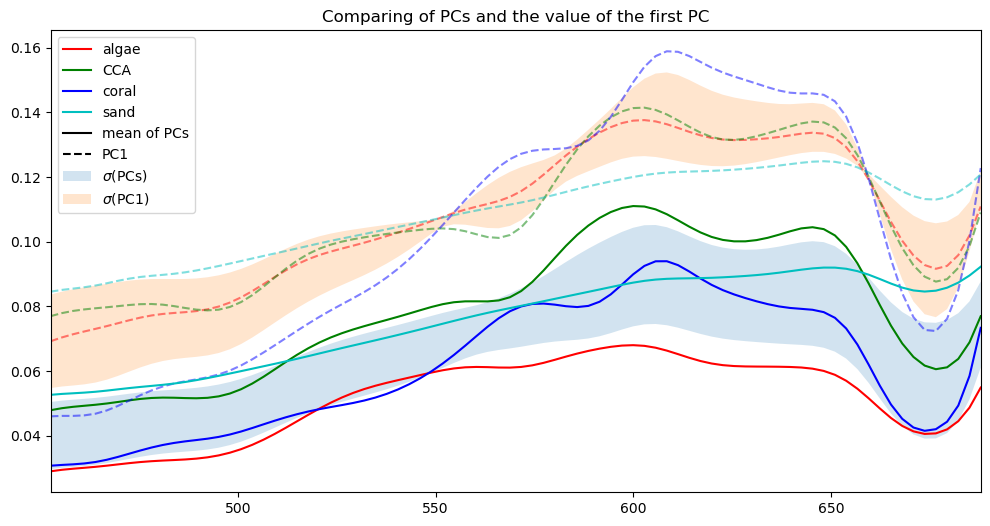

In [57]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
i = 1
cs = ['r', 'g', 'b', 'c']
for i_pca_endmember in range(pc_endmember_array.shape[0]):
    plt.plot(prism_spectra.columns, pc_endmember_array[i_pca_endmember], color=cs[i_pca_endmember], label=list(pc_endmembers.keys())[i_pca_endmember])
    plt.plot(prism_spectra.columns, pc1_endmember_array[i_pca_endmember], ls='--', color=cs[i_pca_endmember], alpha=0.5)

plt.plot([],[], color='k', label='mean of PCs')
plt.plot([],[], color='k', ls='--', label='PC1')

# plot standard deviations
pc_endmember_std = pc_endmember_array.std(axis=0)
pc_endmember_mean = pc_endmember_array.mean(axis=0)
ax.fill_between(prism_spectra.columns, pc_endmember_mean - pc_endmember_std, pc_endmember_mean + pc_endmember_std, alpha=0.2, label="$\\sigma$(PCs)")
    
pc1_endmember_std = pc1_endmember_array.std(axis=0)
pc1_endmember_mean = pc1_endmember_array.mean(axis=0)
ax.fill_between(prism_spectra.columns, pc1_endmember_mean - pc1_endmember_std, pc1_endmember_mean + pc1_endmember_std, alpha=0.2, label="$\\sigma$(PC1)")

plt.title('Comparing of PCs and the value of the first PC')
plt.xlim(prism_spectra.columns.min(), prism_spectra.columns.max())
plt.legend();

In [58]:
partial_wrapper = partial(spectrum_utils._wrapper, of=spectrum_utils.r2_objective_fn, method="Powell", tol=1e-9, prism_spectra=prism_spectra, AOP_args=AOP_args, endmember_array=pc_endmember_array)

# if rerun fitting process
if rerun:
    with mp.Pool() as pool:
        result = list(tqdm(pool.imap(partial_wrapper, prism_spectra.index), total=len(prism_spectra.index)))

  0%|          | 0/1938 [00:00<?, ?it/s]

In [59]:
pc_fits = pd.DataFrame(result, index=prism_spectra.index, columns=['bb', 'K', 'H'] + list(new_cats))
pc_fits.head()

,bb,K,H,algae,CCA,coral,sand
0,0.41123,0.01688,11.194334,0.132697,0.191767,0.146394,0.185041
1,0.41123,0.01688,11.196272,0.131806,0.190444,0.145432,0.183724
2,0.41123,0.01688,12.815805,0.111820,0.160076,0.123091,0.153768
3,0.41123,0.01688,12.804942,0.106668,0.153563,0.117241,0.148713
4,0.41123,0.01688,11.197754,0.128255,0.185423,0.141477,0.179120


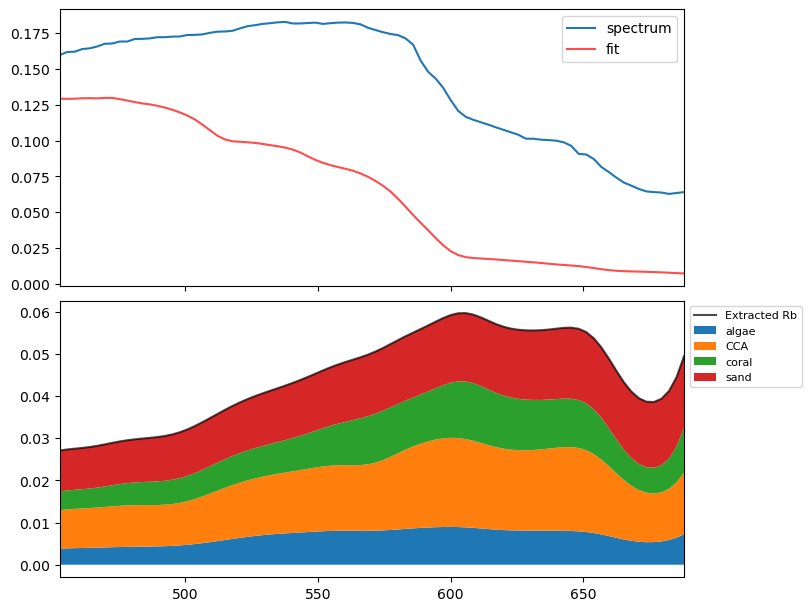

In [60]:
i = 1

fig, axs = plt.subplots(2, 1, sharex=True, constrained_layout=True, figsize=(8,6))

axs[0].plot(prism_spectra.columns, prism_spectra.loc[i], label='spectrum');
bb, K, H = pc_fits.iloc[i,:][:3]    # TODO: is there a better way to make this generic? Probably via feeding [bb, K, H] as single argument (a list)
axs[0].plot(prism_spectra.columns, spectrum_utils.sub_surface_reflectance_Rb(prism_spectra.columns, pc_endmember_array, bb, K, H, AOP_args, *pc_fits.iloc[i,:][3:]), color='red', alpha=0.7, label='fit')
axs[0].legend(bbox_to_anchor=(1,1))

axs[1].plot(prism_spectra.columns, spectrum_utils.Rb_endmember(pc_endmember_array, *pc_fits.iloc[i,:][-4:]), color='k', alpha=0.7, label='Extracted Rb')

axs[1].set_xlim(prism_spectra.columns.min(), prism_spectra.columns.max())

endmember_contribution = pc_endmember_array * pc_fits.iloc[i,:][-4:].values.reshape(-1,1)
y = np.zeros(endmember_contribution.shape[1])
for label, endmember in zip(pc_endmembers, endmember_contribution):
    ynew = y + endmember
    axs[1].fill_between(prism_spectra.columns, y, ynew, label=label, lw=0)
    y = ynew
    
axs[1].legend(bbox_to_anchor=(1,1), fontsize=8)


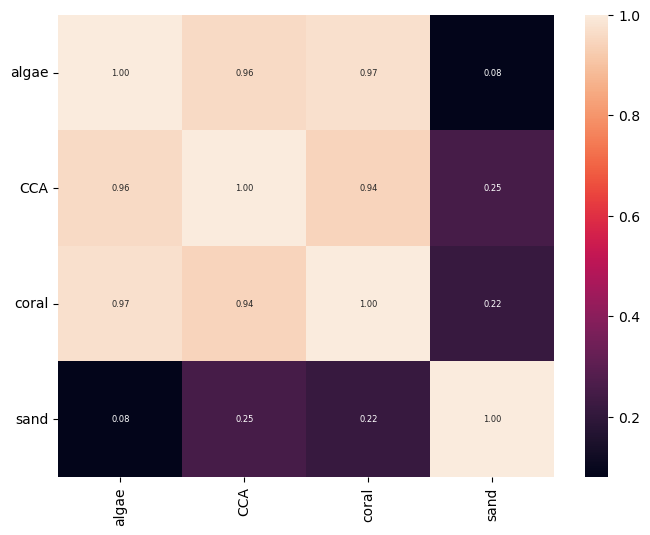

In [61]:
plt.figure(figsize=[8,6])
ax = sns.heatmap(np.corrcoef(pc_endmember_array[:, 44:]), annot=True, fmt='.2f', annot_kws={'fontsize':6})
ax.set_xticklabels(pc_endmembers.keys(), rotation=90)
ax.set_yticklabels(pc_endmembers.keys(), rotation=0);

## Simulation

TypeError: cannot unpack non-iterable int object

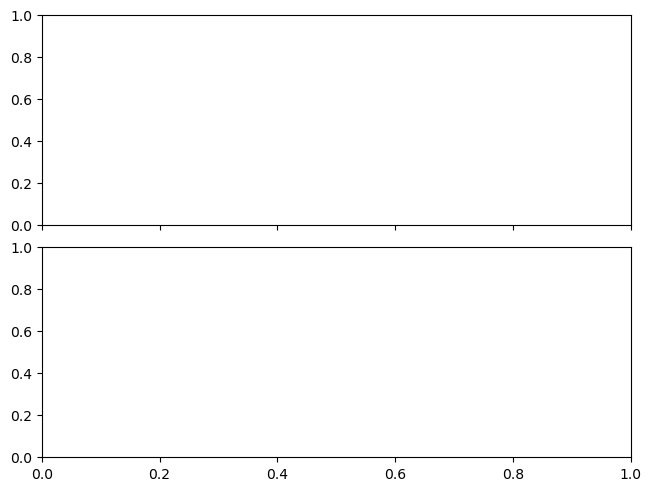

In [62]:
bb = 0.02
K = 0.2
H = 10

Rb0 = 0  # algae
Rb1 = 0  # CCA
Rb2 = 0.5  # coral
Rb3 = 0  # sand

def sub_surface_reflectance_Rb(wv, bb, K, H, Rb0, Rb1, Rb2, Rb3, bb_m, bb_c, Kd_m, Kd_c):
    Rb = spectrum_utils.Rb_endmember(Rb0, Rb1, Rb2, Rb3)
    return sub_surface_reflectance(wv, bb, K, H, Rb, bb_m, bb_c, Kd_m, Kd_c)

fig, axs = plt.subplots(2, 1, sharex=True, constrained_layout=True)

axs[0].plot(prism_spectra.columns, spectrum_utils.sub_surface_reflectance_Rb(prism_spectra.columns, endmember_array, bb, K, H, 0, 0, 0, 0, *AOP_args), label='Rb=0')

cmap = plt.cm.viridis
cnorm = Normalize(vmin=0, vmax=6)

for Rb2 in np.linspace(0, 6, 10):

    sim = spectrum_utils.sub_surface_reflectance_Rb(prism_spectra.columns, bb, K, H, Rb0, Rb1, Rb2, Rb3, *AOP_args) 
    # sim += np.random.normal(0, 1e-4, len(prism_spectra.columns))

    axs[0].plot(prism_spectra.columns, sim, color=cmap(cnorm(Rb2)))

    axs[1].plot(prism_spectra.columns, spectrum_utils.Rb_endmember(Rb0, Rb1, Rb2, Rb3), color=cmap(cnorm(Rb2)))

ma = plt.cm.ScalarMappable(cmap=cmap, norm=cnorm)
fig.colorbar(ma, ax=axs[0])

In [ ]:
# investigating effect of adding noise
bb = 0.02
K = 0.2
H = 5

Rb0 = 0.1  # algae
Rb1 = 0.25  # CCA
Rb2 = 0.5  # coral
Rb3 = 0  # sand



sim = spectrum_utils.sub_surface_reflectance_Rb(wv, bb, K, H, Rb0, Rb1, Rb2, Rb3, *AOD_args) 
sim += np.random.normal(0, 1e-4, len(wv))

fig, axs = plt.subplots(2, 1, sharex=True, constrained_layout=True)

axs[0].plot(wv, spectrum_utils.sub_surface_reflectance_Rb(wv, bb, K, H, 0, 0, 0, 0, *AOD_args), label='Rb=0')

axs[0].plot(wv, sim)

axs[1].plot(wv, spectrum_utils.Rb_endmember(Rb0, Rb1, Rb2, Rb3), color='C1')

w = 1

fit = minimize(spectrum_utils.objective_fn_w,
            x0=[0.1, 0.1, 0] + [0] * 4,
            args=(sim, w, *AOD_args),
            bounds=[(0, 0.41123), (0.01688, 3.17231), (0, 50)] + [(0, np.inf)] * 4, tol=1e-9)

pred = spectrum_utils.sub_surface_reflectance_Rb(wv, *fit.x, *AOD_args)
axs[0].plot(wv, pred, color='C2', alpha=0.7, label='fit')

axs[1].plot(wv, spectrum_utils.Rb_endmember(*fit.x[-4:]), color='C2', alpha=0.7, label='Extracted Rb')

fit.x[-4:] / [Rb0, Rb1, Rb2, Rb3]

In [ ]:
plt.plot(wv,1 + 4 * stats.norm.pdf(wv, loc=570, scale=20))


In [ ]:
plt.plot(wv,1 + 4 * stats.norm.cdf(wv, loc=580, scale=20))